# PythonによるscRNA-seq解析

必要なデータのダウンロードとツールのインストール。

In [1]:
!git clone https://github.com/khigashi1987/scRNAseq_handson.git

Cloning into 'scRNAseq_handson'...
remote: Enumerating objects: 101, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 101 (delta 14), reused 31 (delta 8), pack-reused 64
Receiving objects: 100% (101/101), 303.52 MiB | 17.97 MiB/s, done.
Resolving deltas: 100% (26/26), done.
Updating files: 100% (29/29), done.


In [2]:
!pip install scanpy scikit-misc python-igraph leidenalg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 79.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 60.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 7.0 MB/s eta 0:00:00
  Created wheel for python-igraph: filename=python_igraph-0.10.4-py3-none-any.whl size=9073 sha256=

In [3]:
 !pip install scvelo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.0/220.0 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 57.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.3/53.3 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for loompy: filename=loompy-3.0.7-py3-none-any.whl size=52018 sha256=a794f76487948cb28ddfcdf566157c24d6cd14420287a5961df11560918aa9ac
  Stored in directory: /root/.cache/pip/wheels/2c/22/1f/792a4621bb631e538bf1c21feae9bbaa6b19fd6d6ab382d1fd
  Created wheel for numpy-groupies: filename=numpy_groupies-0.9.22-py3-none-any.whl size=25846 sha256=2bc201258e36e60174a773663817f34c2c59dc44fd69f412f31dc44ac2f46c50
  Stored in directory: /root/.cache/pip/wheels/5b/ce/73/9192b12bb05cc6a44ba159cb733270b1539004037302a42077
Successfully built loompy numpy-groupies


In [4]:
!pip install --quiet scvi-colab
from scvi_colab import install
install()

INFO     scvi-colab: Installing scvi-tools.                                                                        
INFO     scvi-colab: Install successful. Testing import.                                                           


/usr/local/lib/python3.10/dist-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/usr/local/lib/python3.10/dist-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [5]:
%cd scRNAseq_handson

/content/scRNAseq_handson


## 使用データ

マウス15.5日胚の眼球から取り出した網膜の細胞。10X Chromium 3′ v2で解析。2つのReplicatesでそれぞれ約2,600細胞。

Mouse developing retina from Lo Giudice et al. [https://doi.org/10.1242/dev.178103](https://doi.org/10.1242/dev.178103)

Lo Giudice, Q., Leleu, M., La Manno, G. & Fabre, P. J. Single-cell transcriptional logic of cell-fate specification and axon guidance in early-born retinal neurons. Development 146, dev178103 (2019).

## Pythonに関係ない部分の解析

### データのダウンロード

好きな方法で公共データベースからダウンロードする。レプリケイトがふたつあって、それぞれ以下のSRR IDに対応。
```bash
fastq-dump SRR8181428 --split-files --gzip
fastq-dump SRR8181429 --split-files --gzip
```

### Cell Rangerによる解析

Cell Rangerでマウスゲノム（mm10）へのマッピング、遺伝子ごとのカウントを実行。

レプリケイトは（論文でそう名付けられてたので）E2, F2という名前のバッチに設定。

```bash
cellranger count --id=RetinalBatchE2 \
   --fastqs=/path/to/SRR8181428\
   --sample=SRR8181428 \
   --transcriptome=/path/to/Cell_Ranger_References/refdata-gex-mm10-2020-A

cellranger count --id=RetinalBatchF2 \
   --fastqs=/path/to/SRR8181429\
   --sample=SRR8181429 \
   --transcriptome=/path/to/Cell_Ranger_References/refdata-gex-mm10-2020-A
```

講習では、このCell Ranger解析の結果ディレクトリ（の一部、講習で使う部分だけを抜き出したもの）を配布している。

こんな感じの構成になっていて、Cell Rangerのアウトプットが見えるはず。velocytoは後半で解説。

```bash
./data
├── RetinalBatchE2
│   ├── outs
│   │   ├── filtered_feature_bc_matrix
│   │   │   ├── barcodes.tsv.gz
│   │   │   ├── features.tsv.gz
│   │   │   └── matrix.mtx.gz
│   │   └── web_summary.html
│   └── velocyto
│       └── RetinalBatchE2.loom
├── RetinalBatchF2
│   ├── outs
│   │   ├── filtered_feature_bc_matrix
│   │   │   ├── barcodes.tsv.gz
│   │   │   ├── features.tsv.gz
│   │   │   └── matrix.mtx.gz
│   │   └── web_summary.html
│   └── velocyto
│       └── RetinalBatchF2.loom
├── retinal.h5ad
└── retinal_velo.loom

8 directories, 12 files
```

## ライブラリのimport

定番のライブラリのimportに加えて、scanpyをscの別名でimportする。

Figのちょっとした設定。あと一応、筆者の環境における各ライブラリのバージョンは以下の通り。

In [6]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

sc.logging.print_header()
sc.settings.set_figure_params(dpi=100, facecolor='white')

scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.22.4 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.2.2 statsmodels==0.13.5 python-igraph==0.10.4 pynndescent==0.5.10


## データの読み込み

Scanpyの特徴は、データフレームを拡張した ***anndata*** と呼ばれる オブジェクトを使う点にある。anndataを使うと、ひとつのオブジェクトに遺伝子発現量のデータ、サンプルや細胞のアノテーション、遺伝子の情報などをまとめて格納できる。 anndataを使うことで、実験の情報が詰まったひとつのオブジェクトに対して処理を次々に実行し、さらに処理結果をそこに蓄積していくことができる。

Scanpyでは、10x Genomicsのデータは、結果のディレクトリを指定することでそのままロードが可能な関数が用意されている。

ディレクトリには、3つのファイルが書き出されている。

ひとつは、個別の細胞を識別するバーコードが記述されたbarcodes.tsvという名前のテキストファイル。各行ごとにひとつのバーコードが記述されている。

ふたつめは、計測された遺伝子が記述されたgenes.tsvという名前のタブ区切りテキストファイル。このファイルは左側の列に遺伝子のENSEMBL Gene ID、右側の列の遺伝子のシンボルが記述されている。

最後にmatrix.mtxというテキストファイルが、各細胞（バーコード）について各遺伝子の発現がいくつ観測されたのかカウント情報をまとめたファイル。このファイルはMatrix Market Exchange Formatsという形式で記述されており、疎行列（含まれる値の多くがゼロであるような行列）を比較的コンパクトに記述するための形式となっている。

Scanpyの10xデータ用読み込み関数を使うと、これらを同時に読み込んで、適切に構造化されたオブジェクトができあがる。

In [7]:
adata_E2 = sc.read_10x_mtx(path='./data/RetinalBatchE2/outs/filtered_feature_bc_matrix/', cache=True)
adata_F2 = sc.read_10x_mtx(path='./data/RetinalBatchF2/outs/filtered_feature_bc_matrix/', cache=True)

In [8]:
adata_E2

AnnData object with n_obs × n_vars = 3166 × 32285
    var: 'gene_ids', 'feature_types'

In [9]:
adata_F2

AnnData object with n_obs × n_vars = 3299 × 32285
    var: 'gene_ids', 'feature_types'

2つのバッチをひとつのanndataオブジェクトに統合する。バッチのラベルもここで設定。

In [10]:
adata = adata_E2.concatenate(adata_F2, batch_categories=['E2', 'F2'])

観測値（細胞）に関するデータは、**obs** でアクセスする。 observationsの略。このデータフレームに細胞に関するデータを追加していくことができる。

In [11]:
adata.obs

batch
AAACCTGAGATGTCGG-1-E2    E2
AAACCTGCAATCCAAC-1-E2    E2
AAACCTGCACATGGGA-1-E2    E2
AAACCTGCAGCAGTTT-1-E2    E2
AAACCTGGTTCCTCCA-1-E2    E2
...                     ...
TTTGTCACATCGATGT-1-F2    F2
TTTGTCAGTAGAGGAA-1-F2    F2
TTTGTCAGTCATCCCT-1-F2    F2
TTTGTCATCAGTTCGA-1-F2    F2
TTTGTCATCCGAATGT-1-F2    F2

[6465 rows x 1 columns]

変数（遺伝子）に関するデータは、**var** でアクセスする。variable の略。現在は、遺伝子のシンボル（名前）と、Ensembl Gene IDなどが登録されている。

In [12]:
adata.var

gene_ids    feature_types
Xkr4        ENSMUSG00000051951  Gene Expression
Gm1992      ENSMUSG00000089699  Gene Expression
Gm19938     ENSMUSG00000102331  Gene Expression
Gm37381     ENSMUSG00000102343  Gene Expression
Rp1         ENSMUSG00000025900  Gene Expression
...                        ...              ...
AC124606.1  ENSMUSG00000095523  Gene Expression
AC133095.2  ENSMUSG00000095475  Gene Expression
AC133095.1  ENSMUSG00000094855  Gene Expression
AC234645.1  ENSMUSG00000095019  Gene Expression
AC149090.1  ENSMUSG00000095041  Gene Expression

[32285 rows x 2 columns]

カウントテーブルには、以下のように ***X*** でアクセスできる。疎行列として格納されている。

In [13]:
adata.X

<6465x32285 sparse matrix of type '<class 'numpy.float32'>'
	with 10273670 stored elements in Compressed Sparse Row format>

In [14]:
adata

AnnData object with n_obs × n_vars = 6465 × 32285
    obs: 'batch'
    var: 'gene_ids', 'feature_types'

## 前処理

観測された遺伝子が極端に少ない細胞、割り当てられた細胞が極端に少ない遺伝子をフィルタリング。

In [15]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=20)

In [16]:
adata

AnnData object with n_obs × n_vars = 6462 × 13332
    obs: 'batch', 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells'

ミトコンドリア遺伝子の発現割合でフィルタリングする予定なので、遺伝子側のメタデータにミトコンドリア遺伝子か否かの情報を付与。

In [17]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')

以下は、クオリティコントロールに関連したいくつかの指標を一挙に計算してくれる便利な関数。

`qc_vars`に遺伝子側のメタデータラベルを設定すると、それについてもカウントとパーセンテージを勝手に計算してくれる。

In [18]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [19]:
adata.obs

batch  n_genes  n_genes_by_counts  total_counts  \
AAACCTGAGATGTCGG-1-E2    E2     1432               1427        3263.0   
AAACCTGCAATCCAAC-1-E2    E2     1297               1292        2568.0   
AAACCTGCACATGGGA-1-E2    E2      261                261         572.0   
AAACCTGCAGCAGTTT-1-E2    E2      360                359         624.0   
AAACCTGGTTCCTCCA-1-E2    E2     3072               3057       10505.0   
...                     ...      ...                ...           ...   
TTTGTCACATCGATGT-1-F2    F2     1916               1908        3714.0   
TTTGTCAGTAGAGGAA-1-F2    F2     2010               2007        5526.0   
TTTGTCAGTCATCCCT-1-F2    F2     1760               1757        3718.0   
TTTGTCATCAGTTCGA-1-F2    F2     1175               1170        2064.0   
TTTGTCATCCGAATGT-1-F2    F2      443                441         865.0   

                       total_counts_mt  pct_counts_mt  
AAACCTGAGATGTCGG-1-E2            111.0       3.401778  
AAACCTGCAATCCAAC-1-E2             97.0       3.777258  
AAACCTGCACATGGGA-1-E2             47.0       8.216784  
AAACCTGCAGCAGTTT-1-E2             21.0       3.365385  
AAACCTGGTTCCTCCA-1-E2            283.0       2.693955  
...                                ...            ...  
TTTGTCACATCGATGT-1-F2            136.0       3.661820  
TTTGTCAGTAGAGGAA-1-F2            176.0       3.184944  
TTTGTCAGTCATCCCT-1-F2            121.0       3.254438  
TTTGTCATCAGTTCGA-1-F2             54.0       2.616279  
TTTGTCATCCGAATGT-1-F2            305.0      35.260117  

[6462 rows x 6 columns]

それぞれの分布をプロット。

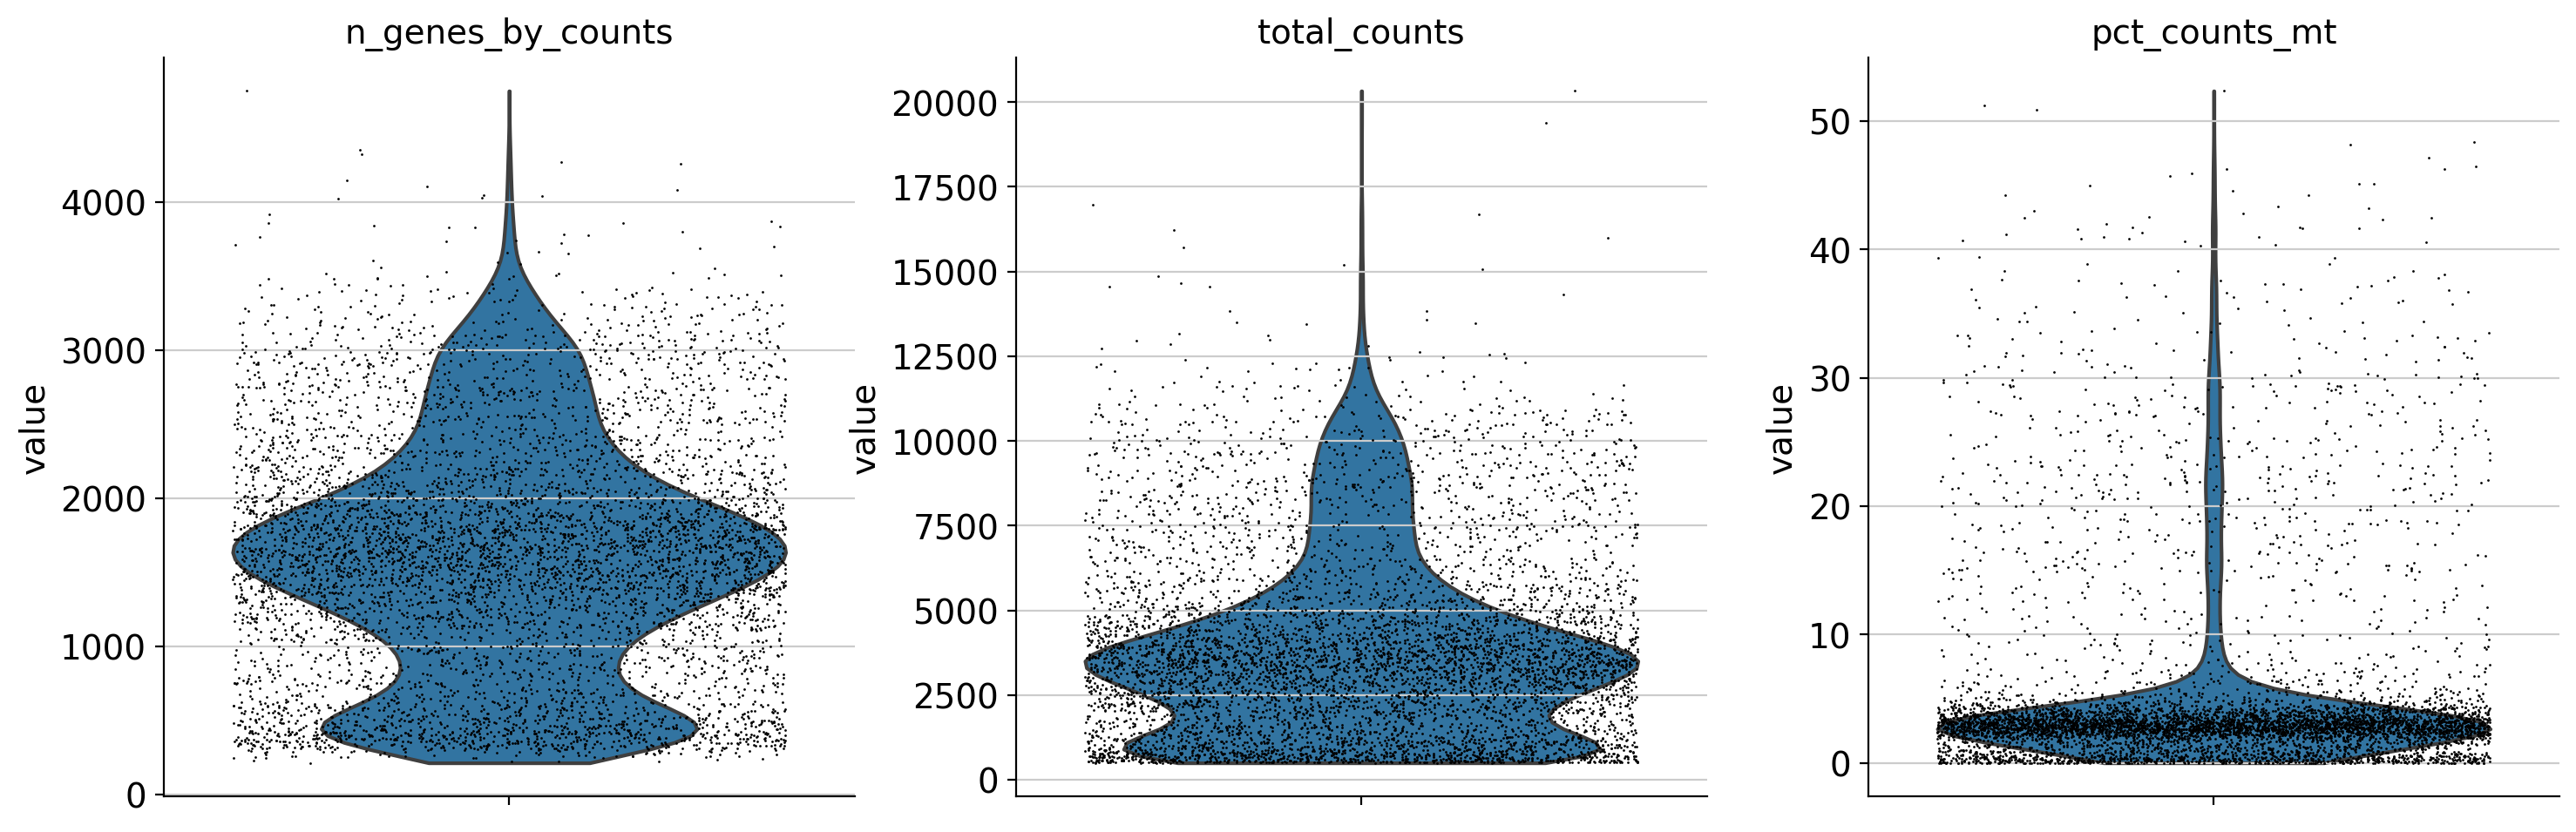

In [20]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

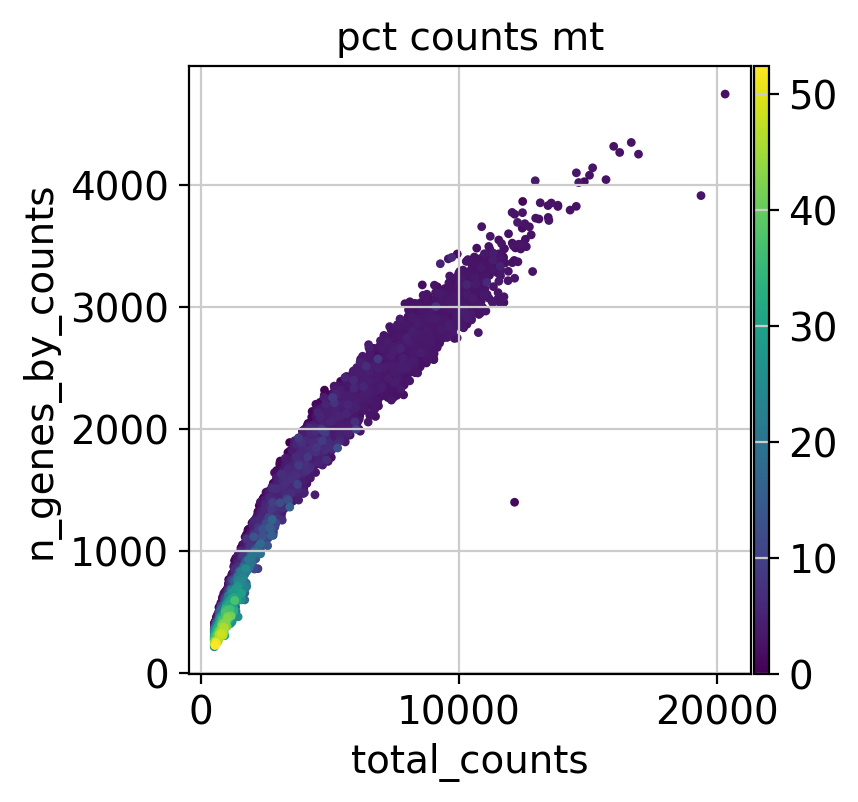

In [21]:
sc.pl.scatter(adata, 'total_counts', 'n_genes_by_counts', color='pct_counts_mt', size=40)

<Figure size 400x400 with 0 Axes>

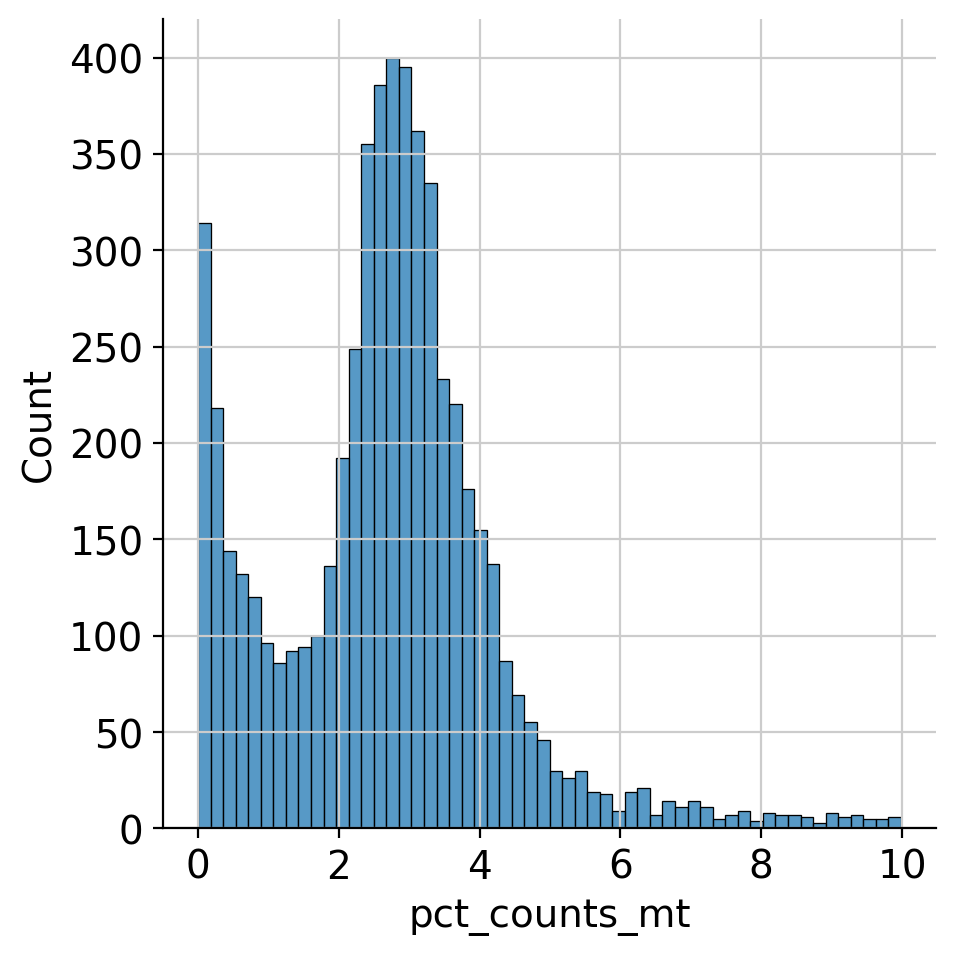

In [22]:
fig = plt.figure()
sns.displot(adata.obs['pct_counts_mt'][adata.obs['pct_counts_mt'] < 10], kde=False)
plt.show()

分布を見て方針を決めて、フィルタリングを実行。

In [23]:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 2000)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 13000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 1000)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['pct_counts_mt'] < 6]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

Total number of cells: 6462
Number of cells after min count filter: 4728
Number of cells after max count filter: 4706
Number of cells after gene filter: 4686
Number of cells after MT filter: 4563


In [24]:
adata

View of AnnData object with n_obs × n_vars = 4563 × 13332
    obs: 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

正規化や対数変換などの前に、この段階のカウントマトリックスを別のレイヤーに退避させておく。あとで確率モデル推定のときに必要になる。レイヤーに保管したデータは基本的に以降の操作の影響を受けないが、細胞や遺伝子のslicingは適用されるので注意。（常にマトリックスのshapeは一致する）

In [25]:
adata.layers['counts'] = adata.X.copy()

## 正規化

ライブラリサイズによる正規化、対数変換などの前処理は、scanpy.pp以下にいくつか便利な関数がある。

ここでは、細胞ごとのカウントの和が10,000になるように正規化してから、対数変換。

In [26]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

この段階のデータ（いろいろとややこしい変換をしていない「ピュア」なデータ）も、あとでプロットや結果解釈のときに使いたいので退避させておく。rawは特別なレイヤーで、数値だけでなくobsやvarのメタデータも含めてフリーズしてくれる。また遺伝子側のsliceの影響を受けない（細胞側のsliceは適用される）

In [27]:
adata.raw = adata

## 特徴量選択（発現量の変動が大きい遺伝子）

発現量変動の大きい遺伝子のみを抽出して、データのサイズを小さくする。

In [28]:
sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=2000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))


 Number of highly variable genes: 2000


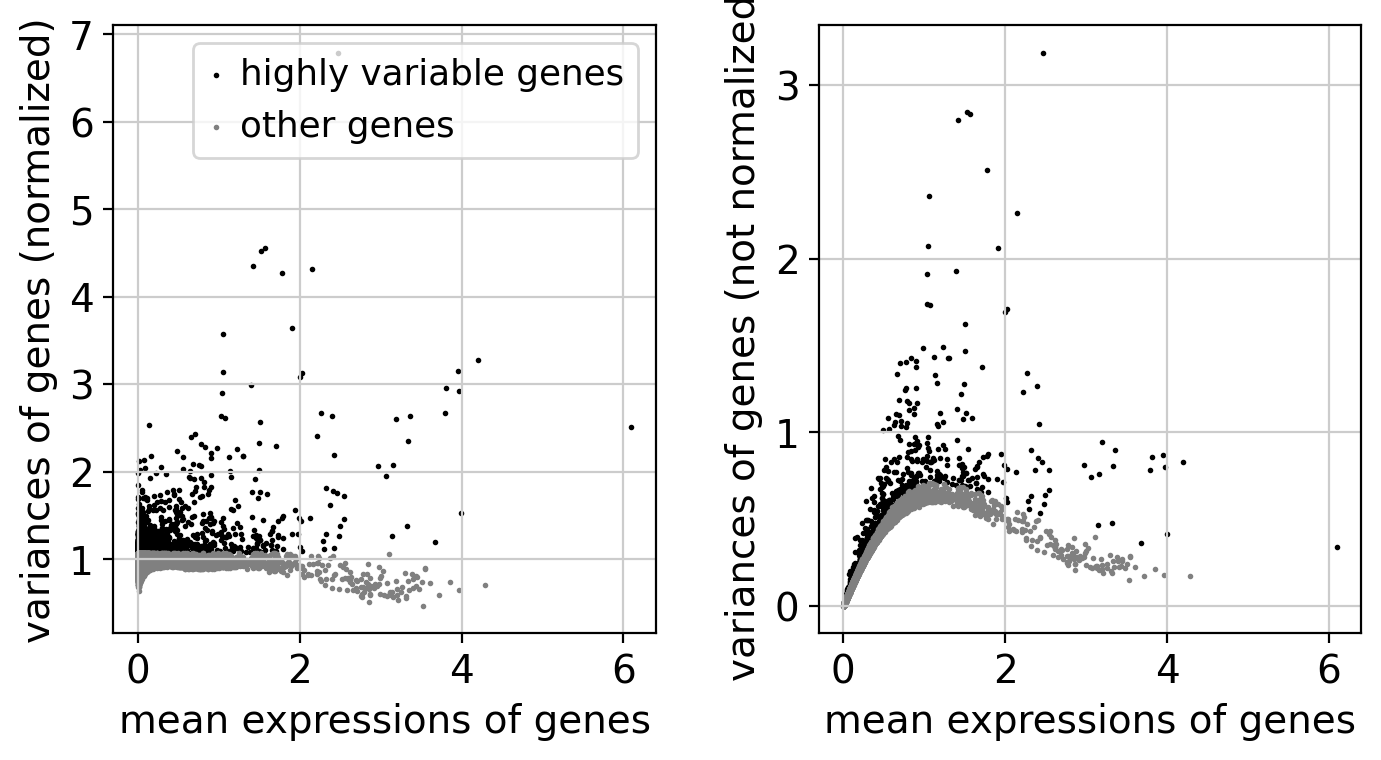

In [29]:
sc.pl.highly_variable_genes(adata)

計算結果は自動的に adata.var 、つまり、遺伝子に関するメタデータを格納したオブジェクトに追加される。 highly_variable の項目が True の遺伝子が高発現変動遺伝子。

In [30]:
adata.var

gene_ids    feature_types  n_cells     mt  \
Xkr4            ENSMUSG00000051951  Gene Expression       89  False   
Gm19938         ENSMUSG00000102331  Gene Expression      578  False   
Mrpl15          ENSMUSG00000033845  Gene Expression     1899  False   
Lypla1          ENSMUSG00000025903  Gene Expression     1284  False   
Tcea1           ENSMUSG00000033813  Gene Expression     2614  False   
...                            ...              ...      ...    ...   
CAAA01118383.1  ENSMUSG00000063897  Gene Expression       96  False   
Vamp7           ENSMUSG00000051412  Gene Expression     1606  False   
Tmlhe           ENSMUSG00000079834  Gene Expression       46  False   
4933409K07Rik   ENSMUSG00000095552  Gene Expression       20  False   
AC149090.1      ENSMUSG00000095041  Gene Expression     1960  False   

                n_cells_by_counts  mean_counts  pct_dropout_by_counts  \
Xkr4                           89     0.013773              98.622717   
Gm19938                       578     0.103528              91.055401   
Mrpl15                       1899     0.375271              70.612813   
Lypla1                       1284     0.241566              80.129991   
Tcea1                        2614     0.631848              59.548128   
...                           ...          ...                    ...   
CAAA01118383.1                 96     0.015166              98.514392   
Vamp7                        1606     0.314144              75.147013   
Tmlhe                          46     0.007119              99.288146   
4933409K07Rik                  20     0.003095              99.690498   
AC149090.1                   1960     0.475085              69.668833   

                total_counts  highly_variable  highly_variable_rank     means  \
Xkr4                    89.0            False                   NaN  0.013526   
Gm19938                669.0            False                   NaN  0.118130   
Mrpl15                2425.0            False                   NaN  0.471746   
Lypla1                1561.0            False                   NaN  0.302353   
Tcea1                 4083.0            False                   NaN  0.704444   
...                      ...              ...                   ...       ...   
CAAA01118383.1          98.0            False                   NaN  0.021325   
Vamp7                 2030.0            False                   NaN  0.395332   
Tmlhe                   46.0            False                   NaN  0.007515   
4933409K07Rik           20.0            False                   NaN  0.003088   
AC149090.1            3070.0            False                   NaN  0.462647   

                variances  variances_norm  
Xkr4             0.013121        0.834873  
Gm19938          0.129846        0.984716  
Mrpl15           0.418216        0.943994  
Lypla1           0.307116        0.989431  
Tcea1            0.549619        0.948720  
...                   ...             ...  
CAAA01118383.1   0.025196        1.020294  
Vamp7            0.365986        0.947294  
Tmlhe            0.008047        0.921716  
4933409K07Rik    0.002459        0.797902  
AC149090.1       0.455644        1.044050  

[13332 rows x 13 columns]

## 主成分分析（PCA）

PCAはscanpyの前処理関数で簡単に実行できる。とりあえず、50次元まで落としてみる。 use_highly_variableのフラグをオンにすると、遺伝子全体ではなく前項で決定した高発現変動遺伝子のみを使って次元削減をする。

In [31]:
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')

PCAで落とした座標は、観察値のメタデータを格納する ***obsm*** に自動的に入る。obsm は Multi-dimensional annotation of observations の略。複数の次元でひとつの何かを表現するような観測値のメタデータがここに格納される。

In [32]:
print(adata.obsm['X_pca'].shape)

(4563, 50)


プロットしてみる。Scanpyでは基本的に「前処理」（Preprocessing）に関わる関数がscanpy.ppに、「プロット」（Plot）に関わる関数がscanpy.plに入っている。

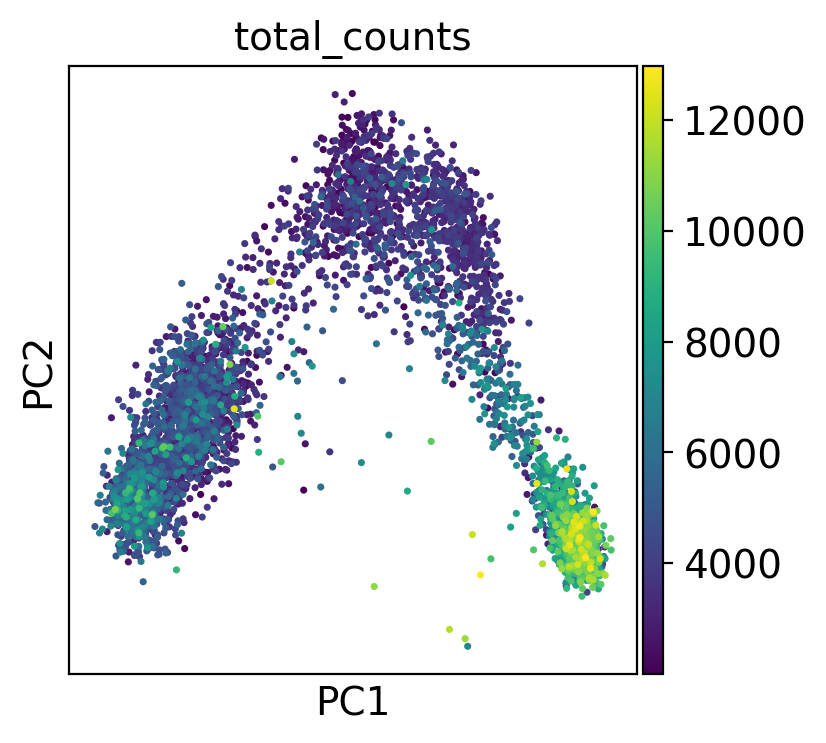

In [33]:
sc.pl.pca(adata, color='total_counts')

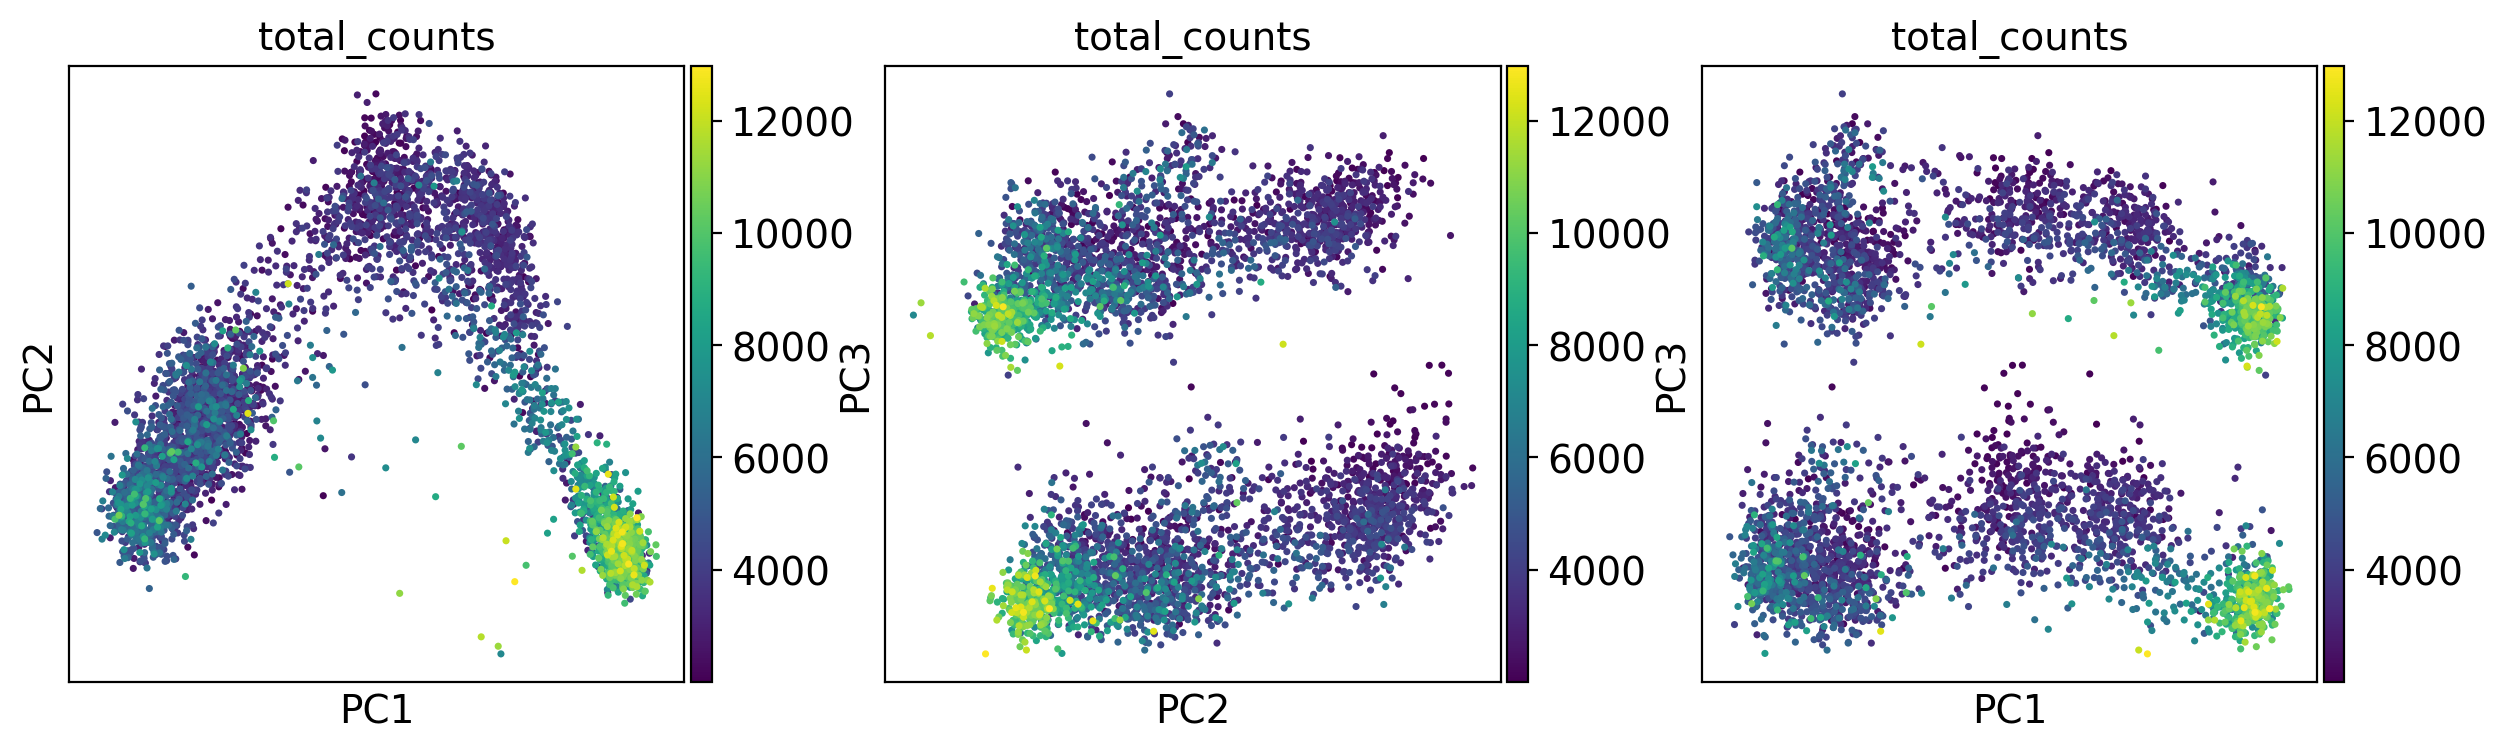

In [34]:
sc.pl.pca(adata, color='total_counts', 
          components=['1,2', '2,3', '1,3'])

In [ ]:
# projection='3d'
# を指定すると3次元表示（見づらい）

## UMAP

まず、t-SNE, UMAP共通のステップとして、データから「近傍グラフ」（neighborhood graph）の構築が必要。

In [35]:
sc.pp.neighbors(adata)

データ点間の接続関係（細胞の近傍関係）は、全細胞vs.全細胞のペアの情報を記録する ***obsp*** （Pairwise annotation of observations の略）に格納される。

In [36]:
adata.obsp['connectivities']

<4563x4563 sparse matrix of type '<class 'numpy.float32'>'
	with 94424 stored elements in Compressed Sparse Row format>

In [37]:
sc.tl.umap(adata)

プロットはt-SNEとほとんど同じ。scanpy.pl以下にUMAP用の描画関数がある。

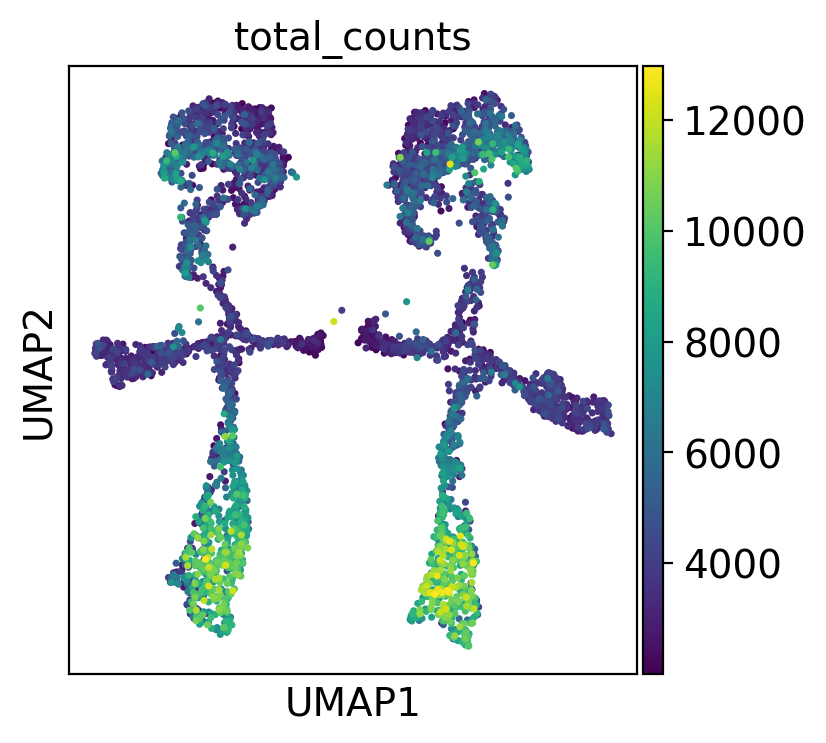

In [38]:
sc.pl.umap(adata, color='total_counts')

あきらかに似た形状の、ふたつの構造がある。。。

各細胞が由来するバッチで色分けしてみると・・・

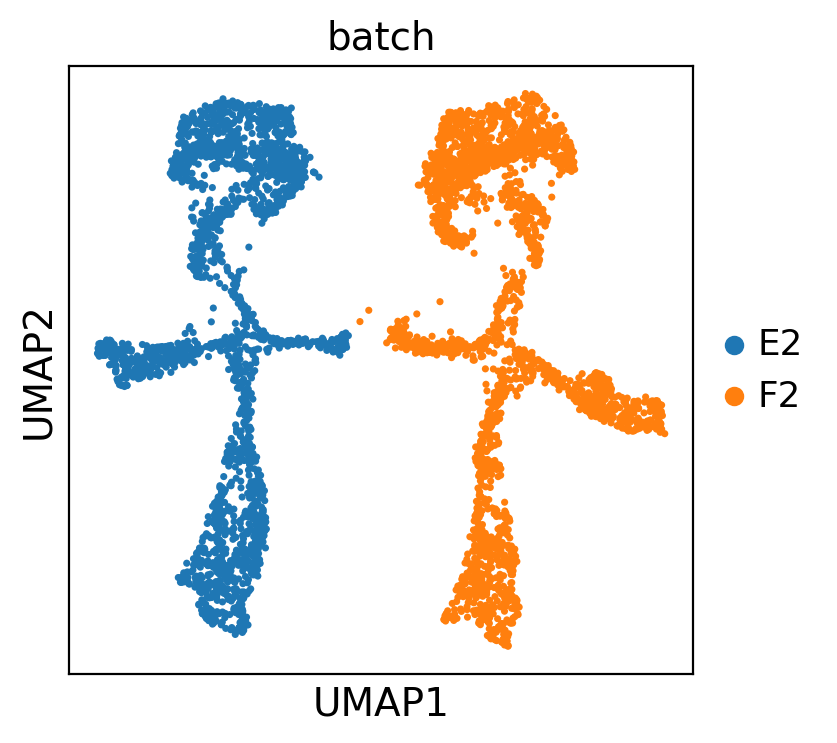

In [39]:
sc.pl.umap(adata, color='batch')

ということで、このふたつの構造はもろにバッチ効果の結果だった。なんらかの方法で補正が必要だが、それは後述。

## クラスタリング

Leidenクラスタリングを実行してみる。モジュラリティの計算に影響を与える "resolution" パラメータが存在する。

In [40]:
sc.tl.leiden(adata, resolution=0.5, key_added='leiden_r0.5')

クラスタリングの結果は観測値のメタデータ（obs）の中に格納される。

In [41]:
adata.obs

batch  n_genes  n_genes_by_counts  total_counts  \
AAACCTGAGATGTCGG-1-E2    E2     1427               1427        3263.0   
AAACCTGCAATCCAAC-1-E2    E2     1292               1292        2568.0   
AAACCTGGTTCCTCCA-1-E2    E2     3057               3057       10505.0   
AAACCTGTCCAATGGT-1-E2    E2     1449               1449        2781.0   
AAACGGGAGGCAATTA-1-E2    E2     2772               2772        9240.0   
...                     ...      ...                ...           ...   
TTTGTCAAGGGCTCTC-1-F2    F2     2393               2393        6209.0   
TTTGTCACATCGATGT-1-F2    F2     1908               1908        3714.0   
TTTGTCAGTAGAGGAA-1-F2    F2     2007               2007        5526.0   
TTTGTCAGTCATCCCT-1-F2    F2     1757               1757        3718.0   
TTTGTCATCAGTTCGA-1-F2    F2     1170               1170        2064.0   

                       total_counts_mt  pct_counts_mt  n_counts leiden_r0.5  
AAACCTGAGATGTCGG-1-E2            111.0       3.401778    3263.0           1  
AAACCTGCAATCCAAC-1-E2             97.0       3.777258    2568.0           1  
AAACCTGGTTCCTCCA-1-E2            283.0       2.693955   10505.0           2  
AAACCTGTCCAATGGT-1-E2             91.0       3.272204    2781.0           8  
AAACGGGAGGCAATTA-1-E2            224.0       2.424242    9240.0           1  
...                                ...            ...       ...         ...  
TTTGTCAAGGGCTCTC-1-F2            143.0       2.303108    6209.0           6  
TTTGTCACATCGATGT-1-F2            136.0       3.661820    3714.0           6  
TTTGTCAGTAGAGGAA-1-F2            176.0       3.184944    5526.0           0  
TTTGTCAGTCATCCCT-1-F2            121.0       3.254438    3718.0           7  
TTTGTCATCAGTTCGA-1-F2             54.0       2.616279    2064.0           5  

[4563 rows x 8 columns]

プロットする点の座標じたいはUMAPの結果なので、プロットはUMAP版の関数を使い、色分けだけをクラスタリング結果で指定すればいい。

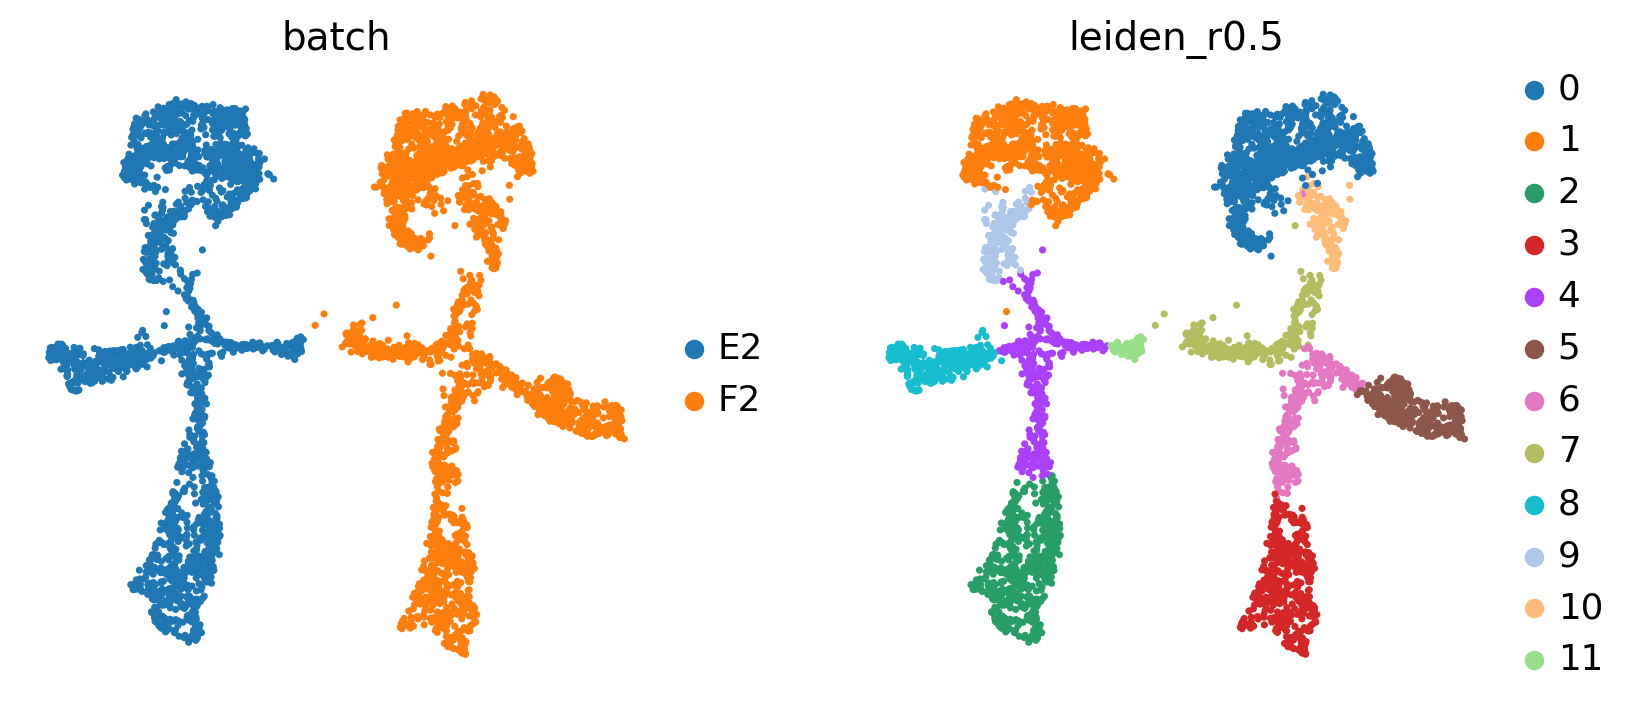

In [42]:
sc.pl.umap(adata,
           color=['batch', 'leiden_r0.5'],
           ncols=2,
           frameon=False)

## 深層生成モデルの利用

scVIが仮定しているデータの生成プロセスは以下の確率モデルに基づく。

全細胞数がN, 細胞のインデックスが $n \in \{1..N\}$、全遺伝子数がG、遺伝子のインデックスが $g \in \{1..G\}$、細胞nのバッチIDが$s_n$であるとしたとき、細胞nの遺伝子gのカウントは、

$$z_n \sim Normal(0, I)$$

$$l_n \sim logNormal(l_\mu, l_\sigma^2)$$

$$\rho_n = f_w (z_n, s_n)$$

$$w_{ng} = Gamma(\rho_n^g, \theta)$$

$$y_{ng} = Poisson(l_n w_{ng})$$

$$h_{ng} = Bernoulli( f_h^g(z_n, s_n) )$$

$$
  \begin{equation}
    x_{ng} =
    \begin{cases}
      y_{ng} & \text{if}\ h_{ng}=0 \\
      0 & \text{otherwise}
    \end{cases}
  \end{equation}
$$

$l_\mu, l_\sigma$は、スケーリングファクターでバッチの数をBとしたとき$l_\mu,l_\sigma \in \mathbb{R}^B$で、実際のバッチごとの平均と分散に設定しておく。

ガンマ分布のパラメータ、ベルヌーイ分布のパラメータは、正規分布からサンプリングした$z_n$を使ってニューラルネットワークで表現する（VAEにおけるreparametrization trick）。

最終的なカウントはガンマとポアソンの複合分布なので、負の二項分布でモデル化してることになる。さらにベルヌーイ分布で、scRNA-seqにありがちなdrop-outイベントを表現。これらの組み合わせで、ゼロ過剰負の二項分布(Zero-inflated negative binomial distribution; ZINB)を表現している。

事後分布はVAEをSGDで最適化して変分推論。

学習後、$z_n$にアクセスすれば、バッチの効果が除去された細胞の潜在ベクトルが得られるし、$\rho_{ng}$にアクセスすればdrop-outなどのイベントが生じなかった場合の遺伝子発現の期待値が得られる。

In [43]:
import scvi

データを格納したanndataオブジェクトと、バッチのIDを指定したobsのカラムのラベルを指定して、モデルをセットアップする。カウントデータの確率モデルなので、（正規化や対数変換したマトリックスではなく）カウントデータを格納したレイヤーを指定する必要があることに注意。

In [44]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer='counts',
    batch_key='batch',
)

モデルを作る。ここで中間層のノード数とか潜在ベクトルの次元サイズなど設定できるが、とくに変更しなくていいと思う。

In [45]:
model = scvi.model.SCVI(adata)

### scVIモデルのトレーニング（バッチ補正）

学習を実行する。GPU使わない場合はめっちゃ時間かかるので今回の講習では割愛。学習済みのモデルパラメータを用意したのでそれをロードして学習できたことにする。

In [46]:
# model.train()

In [47]:
# model.save('./models/scVI_model', overwrite=True)

In [48]:
model = scvi.model.SCVI.load('./models/scVI_model', adata=adata)

INFO     File ./models/scVI_model/model.pt already downloaded                                                      


学習された細胞ごとの潜在表現$z_n$は以下の関数で取得できる。PCAやUMAPの座標と同じように、obsmに格納しておく。

In [49]:
adata.obsm['X_scVI'] = model.get_latent_representation()

発現量期待値 $\rho_{ng}$ 、つまりdenoiseされた発現量テーブルは以下の関数で取得できる。適当なライブラリサイズで規格化してくれる。この数値はあとで使いたいので別のレイヤーに格納しておく。

In [50]:
adata.layers['scvi_normalized'] = model.get_normalized_expression(library_size=1e4)

In [51]:
adata

AnnData object with n_obs × n_vars = 4563 × 13332
    obs: 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden_r0.5', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'batch_colors', 'leiden', 'leiden_r0.5_colors', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_umap', 'X_scVI'
    varm: 'PCs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'distances', 'connectivities'

### scVI潜在表現+UMAPによる次元削減

潜在表現でちゃんとバッチ効果が補正されたかどうか確認してみる。

近傍グラフ計算の `scanpy.pp.neighbors` は、デフォルトではPCAで計算した主成分（adata.obsm['X_pca']）を元にグラフを構築する。ここではPCA結果の座標ではなく、scVIで推定された細胞の潜在ベクトルを指定してグラフ構築してみる。バッチ効果が補正されたグラフが構築されるはず。

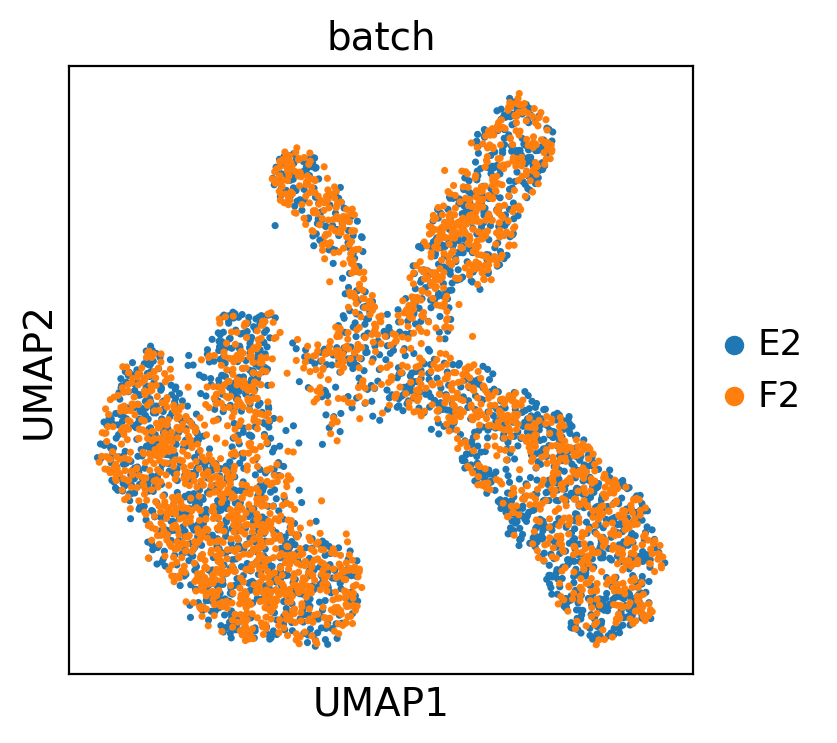

In [52]:
sc.pp.neighbors(adata,
                n_neighbors=30,
                use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.5)
sc.pl.umap(adata, color='batch')

### scVI潜在表現+Leidenによるクラスタリング

同じように、scVI潜在表現で構成された近傍グラフを元にLeidenクラスタリングを実行してみる。上のセルで `scanpy.pp.neighbors` を実行したことにより、adata.obspにはscVI潜在表現で構築された近傍グラフが入っているので、ここでは普通に `scanpy.tl.leiden` を実行すればいい。

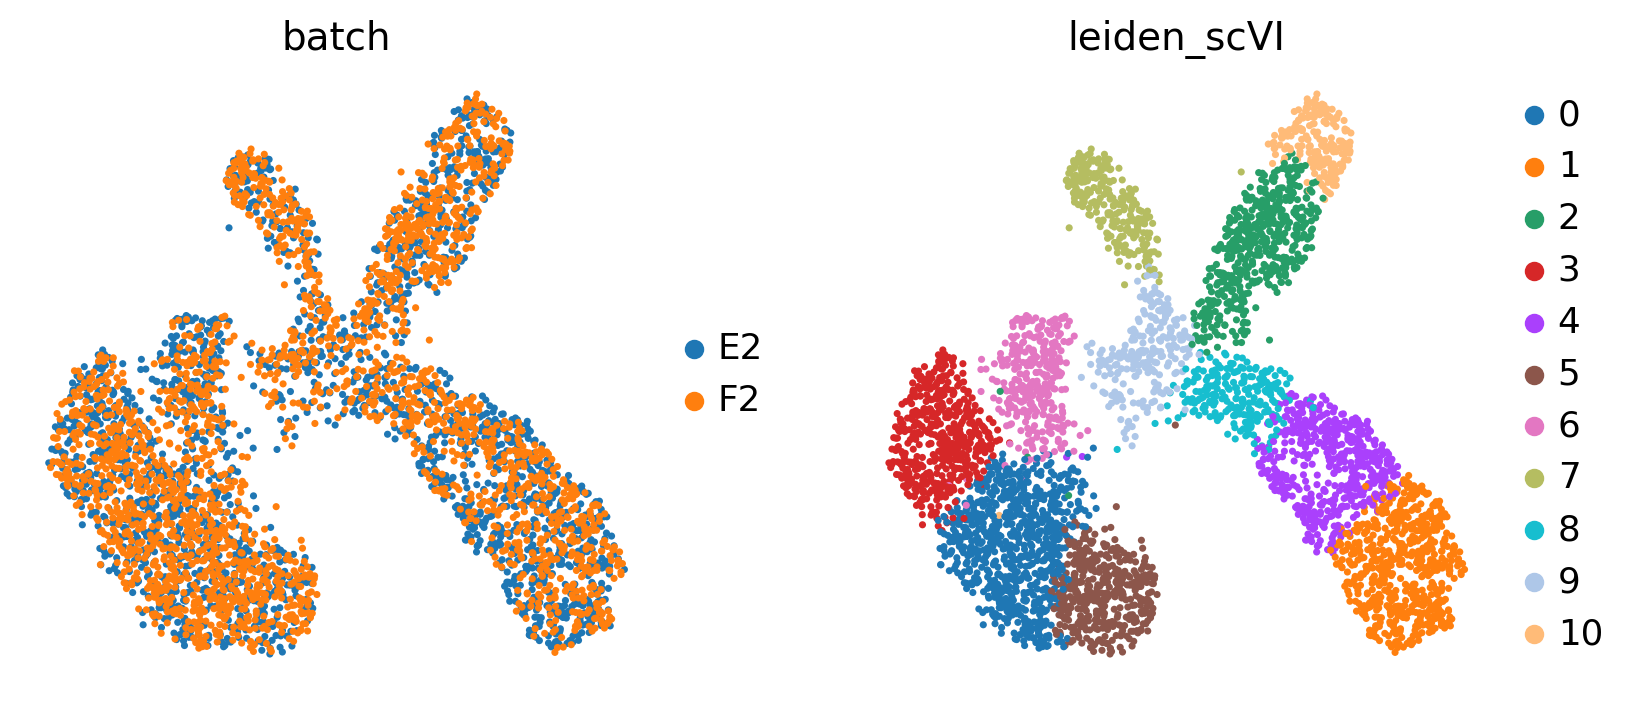

In [53]:
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=1.0)
sc.pl.umap(adata,
           color=['batch', 'leiden_scVI'],
           ncols=2,
           frameon=False)

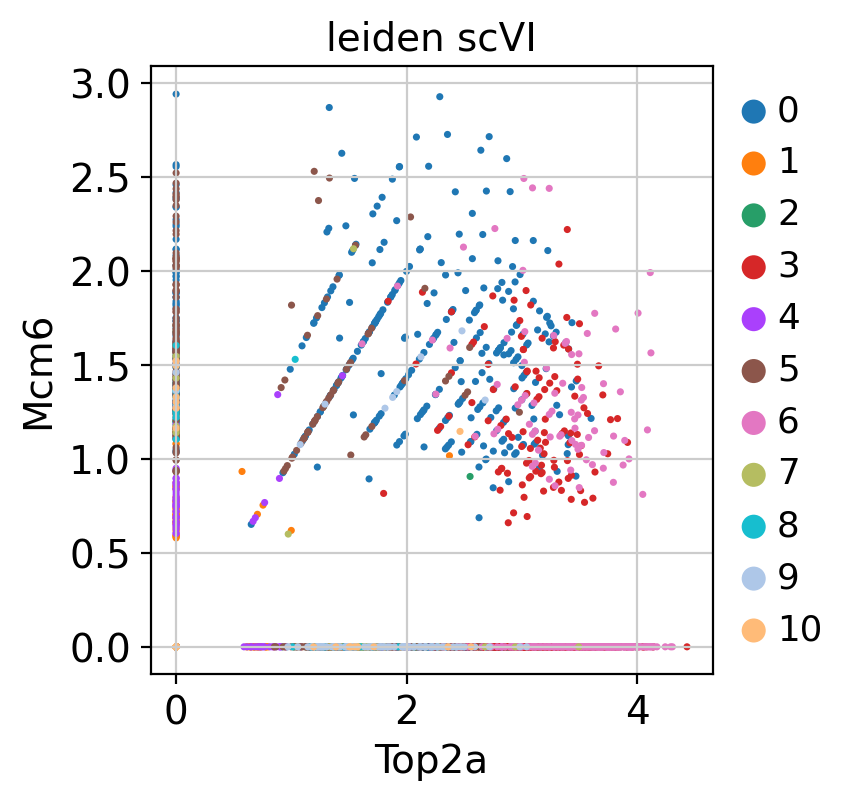

In [54]:
# Top2a, Mcm6の比較でdrop-outが補正されたか確認。
sc.pl.scatter(adata, x='Top2a', y='Mcm6', color='leiden_scVI')

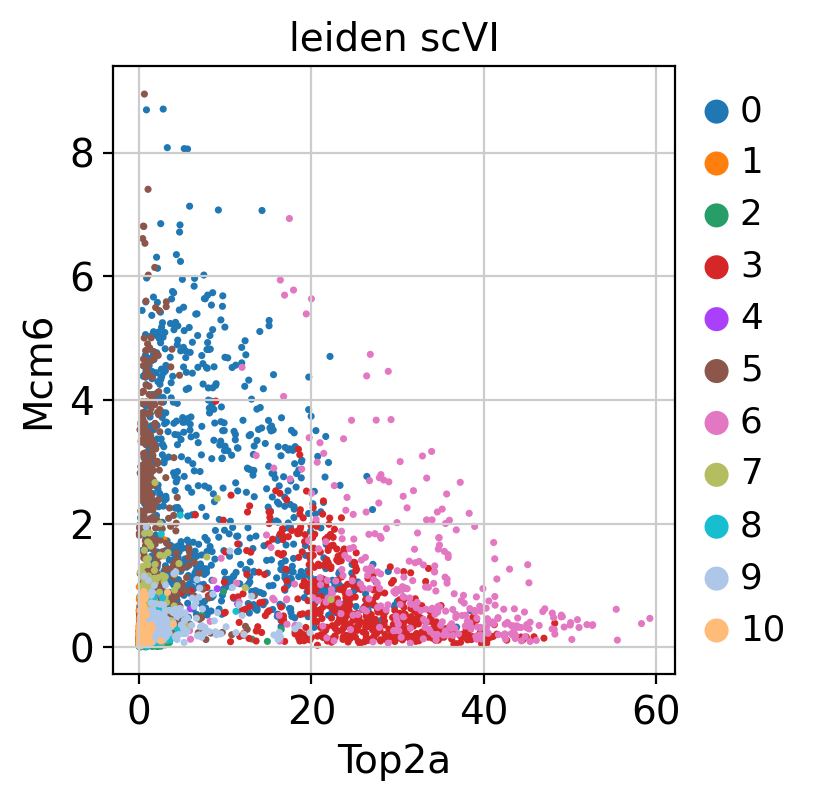

In [55]:
sc.pl.scatter(adata, x='Top2a', y='Mcm6', use_raw=False, layers='scvi_normalized', color='leiden_scVI')

### Doublet検出

[SOLO](https://doi.org/10.1016/j.cels.2020.05.010)によるDoublet検出。

Bernstein, Nicholas J., et al. "Solo: doublet identification in single-cell RNA-Seq via semi-supervised deep learning." Cell systems 11.1 (2020): 95-101.

時間に余裕があればやる。

In [56]:
results = []
for batch in ['F2', 'E2']:
    tmp_solo_model = scvi.external.SOLO.from_scvi_model(
        model, restrict_to_batch=batch)
    tmp_solo_model.train()
    result = tmp_solo_model.predict(soft=False)
    # 意図は不明だがSOLO予測のindexになぜか "-0" が付加されるので消しておく
    result.index = result.index.str.replace("-0$", "", regex=True)
    results.append(result)
results = pd.concat(results)

INFO     Creating doublets, preparing SOLO model.                                                                  


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Epoch 91/400:  23%|██▎       | 91/400 [00:19<01:07,  4.58it/s, v_num=1, train_loss_step=0.115, train_loss_epoch=0.133]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.161. Signaling Trainer to stop.
INFO     Creating doublets, preparing SOLO model.                                                                  


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Epoch 88/400:  22%|██▏       | 88/400 [00:18<01:06,  4.71it/s, v_num=1, train_loss_step=0.18, train_loss_epoch=0.137]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.119. Signaling Trainer to stop.


In [57]:
adata.obs['SOLO_prediction'] = results[adata.obs.index]

In [58]:
adata.obs['SOLO_prediction'].value_counts()

singlet    4192
doublet     371
Name: SOLO_prediction, dtype: int64

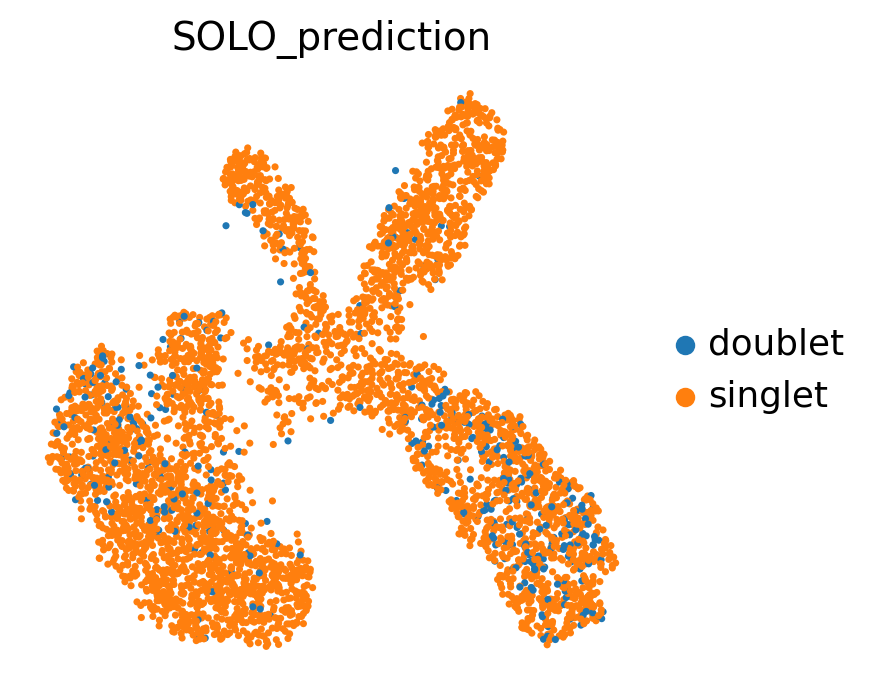

In [59]:
sc.pl.umap(adata, color='SOLO_prediction', frameon=False)

### DEG解析

仮説検定ではなく、ベイズ統計の枠組みでモデル比較を行う。基本的にはある集団と別の集団それぞれの遺伝子発現量期待値（VAEでdenoiseした発現量$\rho_{ng}$）のlog fold changeの値が、ある閾値以下となるか、それ以上の変化があるか、のふたつのモデルで比較する。

`groupby`にラベルを指定すると、そのクラス（この場合はleidenクラスタリングのひとつのクラスタ）とその他全部で自動的に比較してくれる。比較のグループを一部に制限したり、ペアを指定したりいろいろと複雑に組み合わせは指定できる。詳細は[APIのドキュメント](https://docs.scvi-tools.org/en/stable/api/reference/scvi.model.SCVI.html#scvi.model.SCVI.differential_expression)に。

In [60]:
DEs = model.differential_expression(groupby='leiden_scVI')
DEs.head()

DE...: 100%|██████████| 11/11 [02:02<00:00, 11.18s/it]


proba_de  proba_not_de  bayes_factor        scale1    scale2  \
Gfra3      0.9830        0.0170      4.057395  2.696503e-08  0.000010   
Slc6a4     0.9824        0.0176      4.022099  2.765028e-08  0.000005   
Carmil2    0.9824        0.0176      4.022099  2.669958e-07  0.000005   
Nrk        0.9814        0.0186      3.965818  3.007515e-05  0.000003   
Gm26532    0.9814        0.0186      3.965818  3.721261e-05  0.000008   

         pseudocounts  delta  lfc_mean  lfc_median   lfc_std  ...  raw_mean1  \
Gfra3             0.0   0.25 -6.902875   -7.254218  5.057116  ...   0.000000   
Slc6a4            0.0   0.25 -4.876611   -4.955478  7.010310  ...   0.000000   
Carmil2           0.0   0.25 -5.492836   -5.522254  5.261822  ...   0.001264   
Nrk               0.0   0.25  5.996352    5.963952  4.656816  ...   0.025284   
Gm26532           0.0   0.25  5.781958    5.969615  4.829926  ...   0.056890   

         raw_mean2  non_zeros_proportion1  non_zeros_proportion2  \
Gfra3     0.022269               0.000000               0.016702   
Slc6a4    0.012195               0.000000               0.007423   
Carmil2   0.015907               0.001264               0.015642   
Nrk       0.006098               0.020228               0.005302   
Gm26532   0.012725               0.045512               0.009809   

         raw_normalized_mean1  raw_normalized_mean2  is_de_fdr_0.05  \
Gfra3                0.000000              0.037028            True   
Slc6a4               0.000000              0.013267            True   
Carmil2              0.001908              0.021632            True   
Nrk                  0.067514              0.012810            True   
Gm26532              0.145096              0.024545            True   

         comparison  group1 group2  
Gfra3     0 vs Rest       0   Rest  
Slc6a4    0 vs Rest       0   Rest  
Carmil2   0 vs Rest       0   Rest  
Nrk       0 vs Rest       0   Rest  
Gm26532   0 vs Rest       0   Rest  

[5 rows x 22 columns]

それぞれのクラスタ「特異的」遺伝子、DEG確率の高い順に上から3つくらい見てみる。

In [61]:
markers = {}
for i, c in enumerate(adata.obs['leiden_scVI'].unique()):
    comparison_label = "{} vs Rest".format(c)
    cluster_df = DEs.loc[DEs['comparison'] == comparison_label]
    cluster_df = cluster_df[cluster_df['lfc_mean'] > 0]
    cluster_df = cluster_df[cluster_df['bayes_factor'] > 3]
    cluster_df = cluster_df[cluster_df['non_zeros_proportion1'] > 0.1]
    markers[c] = cluster_df.index.tolist()[:3]

図でLeidenクラスタのデンドログラムを表示したいので事前に計算しておく。

In [62]:
sc.tl.dendrogram(adata, groupby='leiden_scVI', use_rep='X_scVI')

クラスタ間での遺伝子発現量の比較は、`scanpy.pl.dotplot`が見やすくて便利。上で抽出したマーカー遺伝子を指定して、表示する発現量の数値としてはadata.rawに格納したデータで描画する。

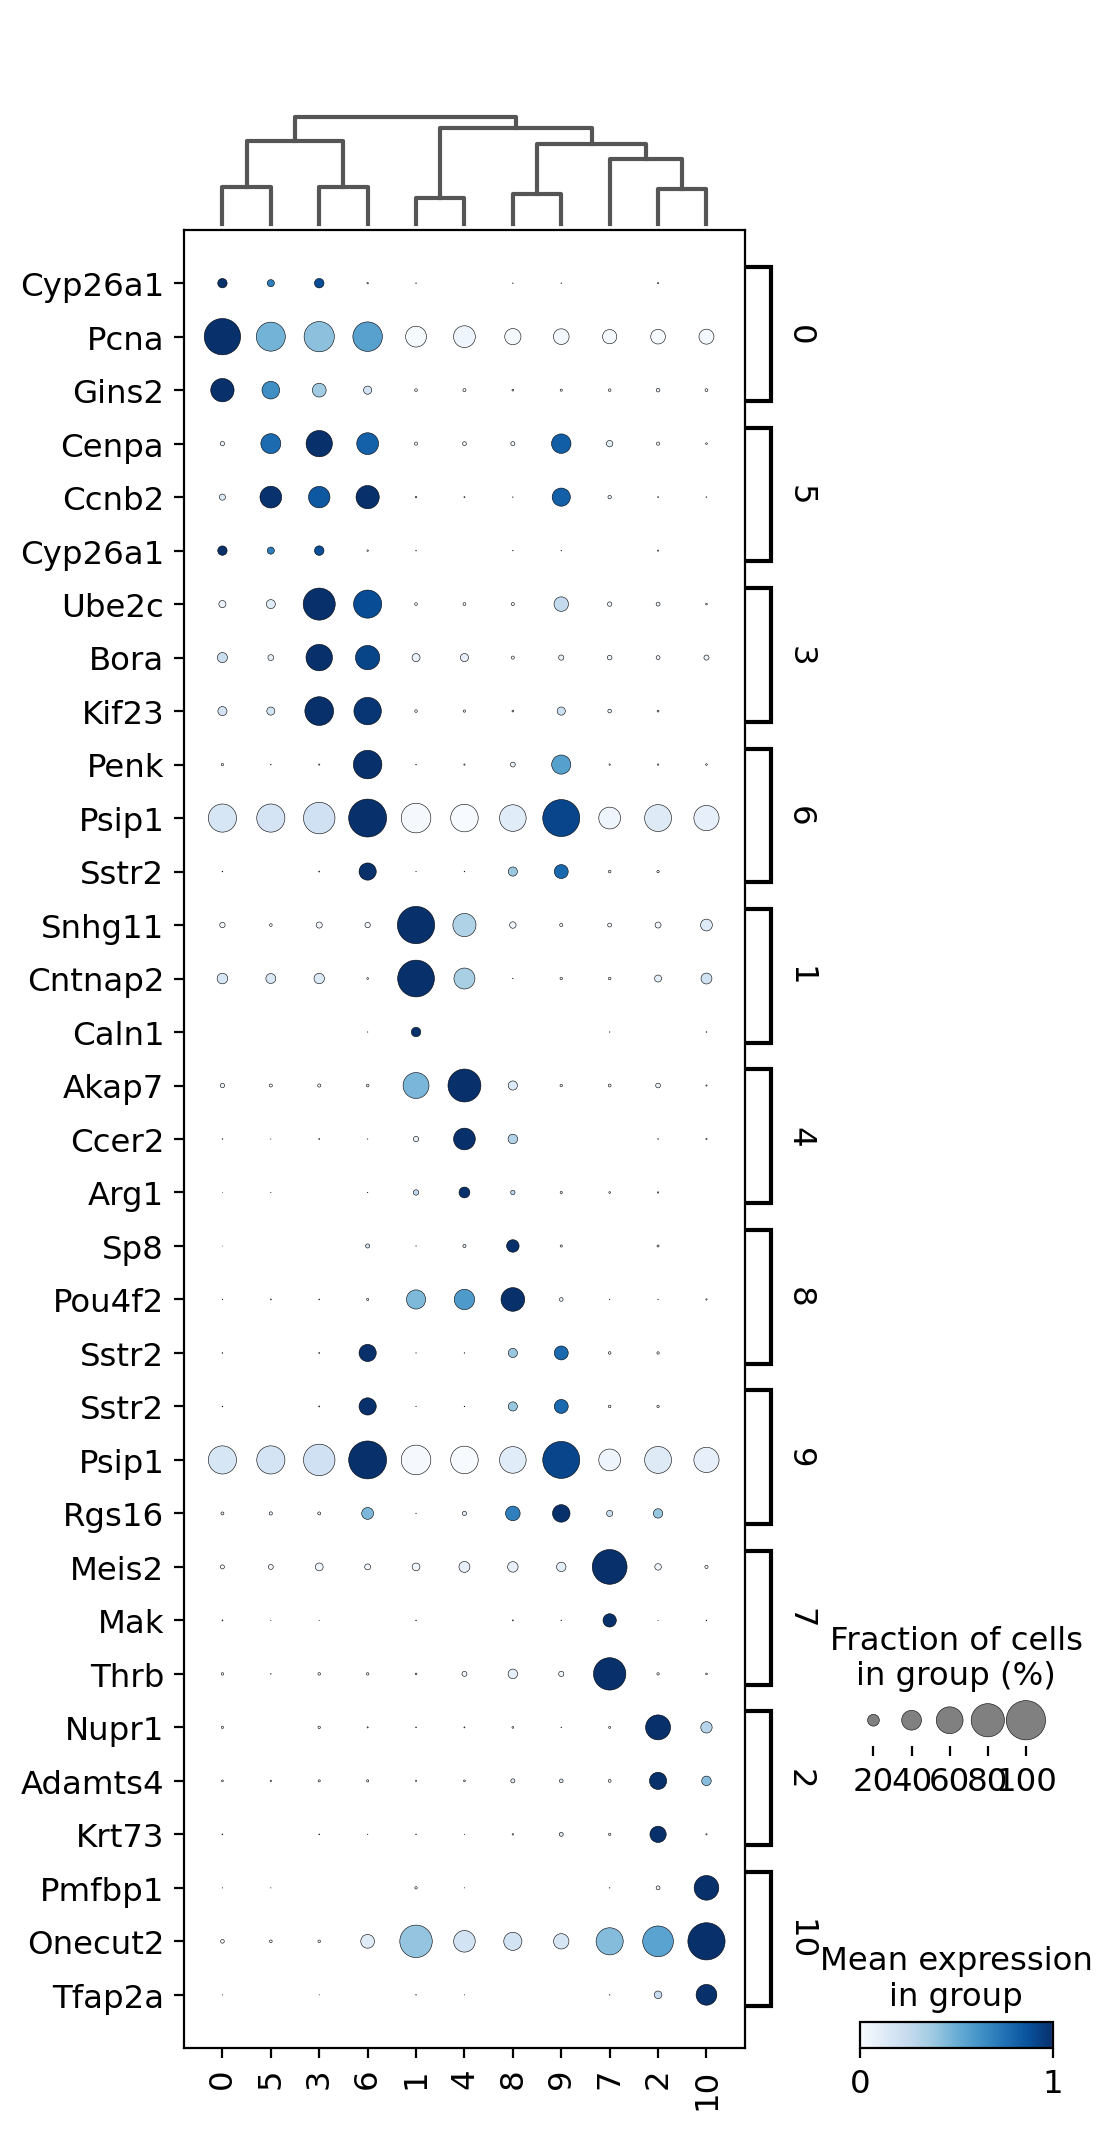

In [63]:
sc.pl.dotplot(
    adata,
    markers,
    groupby='leiden_scVI',
    dendrogram=True,
    color_map="Blues",
    swap_axes=True,
    use_raw=True,
    standard_scale='var')

クラスタ平均値ではなくクラスタごと細胞ごとの全部の（scVIノーマライズされた）発現量でヒートマップを描くこともできる。

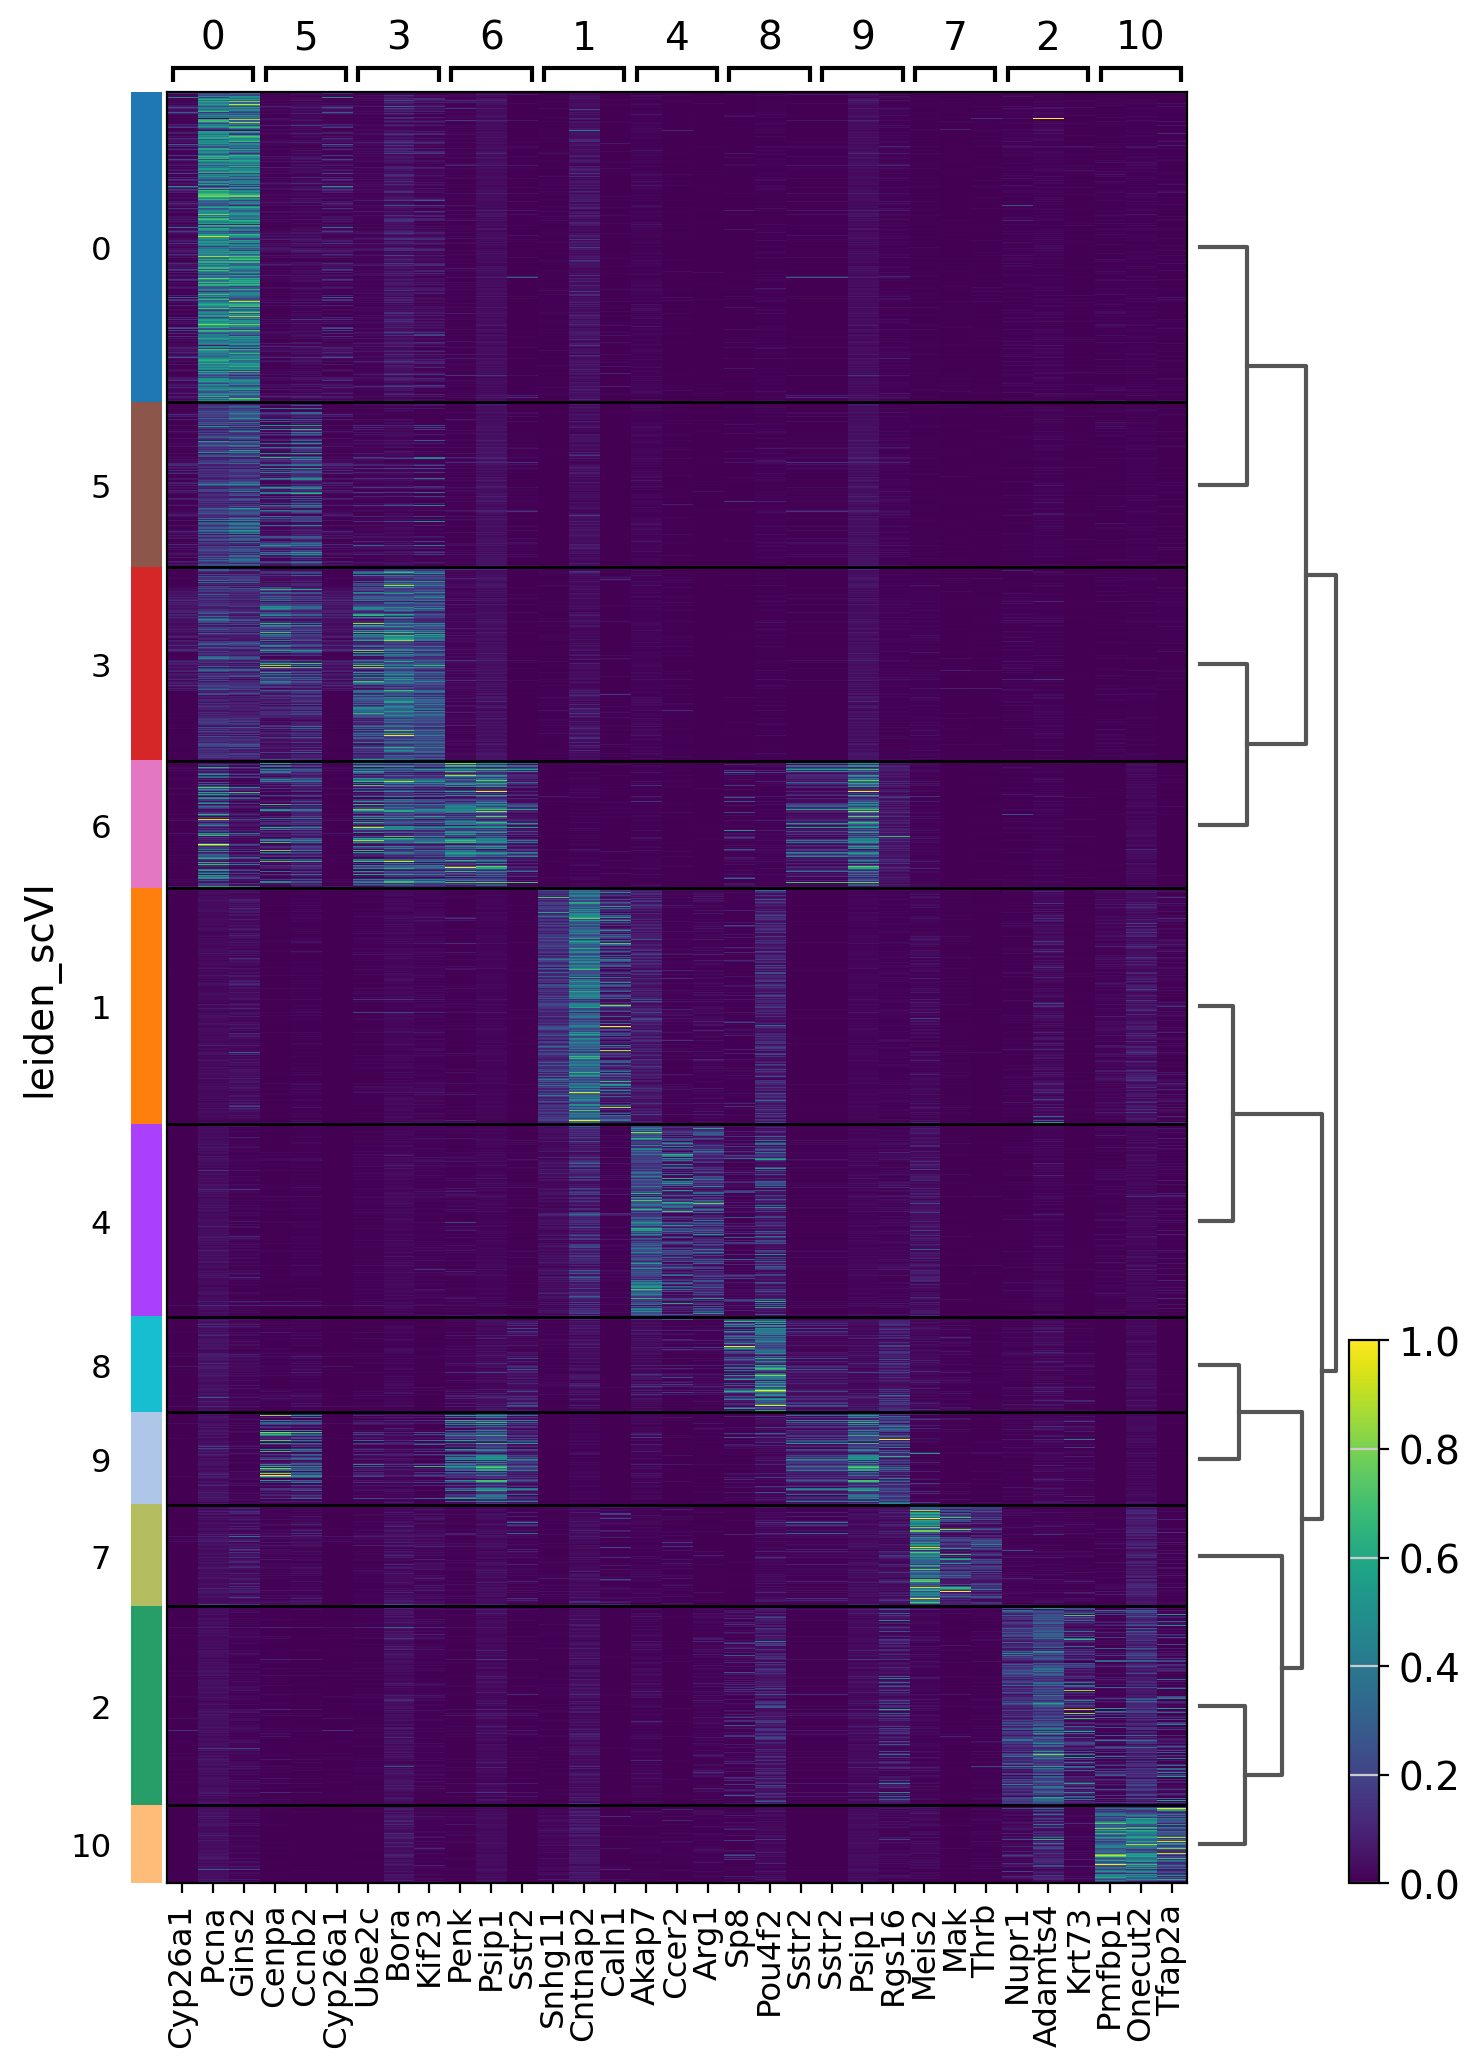

In [64]:
sc.pl.heatmap(
    adata,
    markers,
    groupby='leiden_scVI',
    layer='scvi_normalized',
    standard_scale="var",
    dendrogram=True,
    figsize=(8, 12)
)

## RNA速度の推定

### 事前準備（velocyto）

scVeloを使うためには、spliced/unsplicedの二種類のカウントデータが必要となる。

なので事前に [velocyto](http://velocyto.org/velocyto.py/index.html) を使って、Cell Rangerが生成したゲノムマッピングのBAMファイルから、spliced/unsplicedのカウントデータを作っておく。

バッチごとに実行して、それぞれのバッチに属する細胞のspliced/unsplicedカウントを格納した [loom](https://linnarssonlab.org/loompy/index.html) データを作る。

計算に時間がかかるので、講習ではすでにvelocyto計算済みの結果を配布している。

velocytoは以下のコマンドで実行する。

```bash
velocyto run10x \
    -m /path/to/Cell_Ranger_References/mm10_rmsk.gtf \
    /path/to/RetinalBatchE2 \
    /path/to/Cell_Ranger_References/refdata-gex-mm10-2020-A/genes/genes.gtf

velocyto run10x \
    -m /path/to/Cell_Ranger_References/mm10_rmsk.gtf \
    /path/to/RetinalBatchF2 \
    /path/to/Cell_Ranger_References/refdata-gex-mm10-2020-A/genes/genes.gtf
```

velocytoでバッチごとに推定したloomファイルを統合して書き出す。ここの統合処理も時間かかるので、統合後のデータを配布。

In [65]:
%%script true
import loompy
loompy.combine(['./data/RetinalBatchE2/velocyto/RetinalBatchE2.loom',
                './data/RetinalBatchF2/velocyto/RetinalBatchF2.loom'],
               output_file='./data/retinal_velo.loom')

In [66]:
import scvelo as scv
scv.set_figure_params()

spliced/unsplicedのカウントデータを遺伝子発現テーブルと統合する。細胞のバーコードで紐づけるので、長さの指定（インデックスのどの部分がバーコードか）が必要になることに注意。

In [67]:
ldata = scv.read('./data/retinal_velo.loom', cache=True)

# id_lengthは細胞を区別するバーコード配列の長さ。事前に確認しておく
# また、scVIのmerge関数は勝手にこれまでのクラスタの色指定をリセットしちゃうので一時退避させて再設定しておく
# 'uns'(unstructured)は特に構造の決まってない雑多なメタデータを格納しておく場所。
cluster_colors = adata.uns['leiden_scVI_colors']
adata = scv.utils.merge(adata, ldata, id_length=16)
adata.uns['leiden_scVI_colors'] = cluster_colors

scVeloの関数で、遺伝子ごとのspliced/unsplicedカウントの比率を表示できる。実験プラットフォームにもよるが、だいたいunsplicedが25%程度らしい。クラスタごとにも表示。極端にunsplicedがとれてないクラスタがあるかどうかチェックする。

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


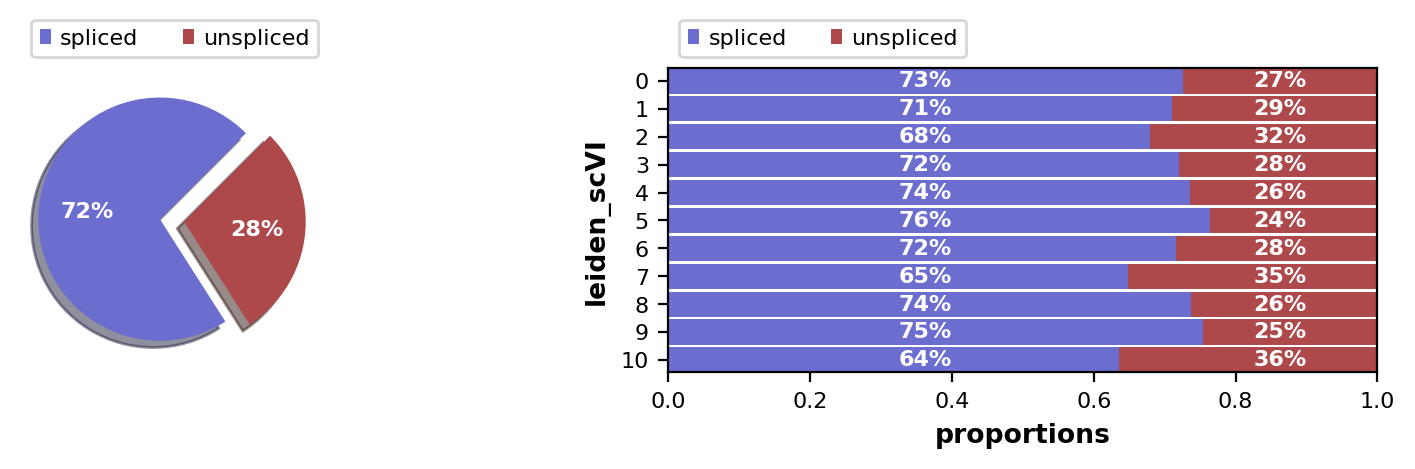

In [68]:
scv.pl.proportions(adata, groupby='leiden_scVI')

速度計算を実行する。近傍グラフの構成から。

In [69]:
# scVI補完の潜在空間上で近傍グラフ構成、一次・二次モーメント計算
scv.pp.moments(adata, use_rep='X_scVI')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Normalized count data: spliced, unspliced.
computing moments based on connectivities
    finished (0:00:04) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


Splicing kineticsモデルのパラメータ推論。

In [70]:
scv.tl.velocity(adata, mode='stochastic')

computing velocities


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


    finished (0:00:14) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


速度ベクトルを元に、細胞から細胞への遷移確率を計算。

In [71]:
scv.tl.velocity_graph(adata)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


computing velocity graph (using 1/2 cores)


  0%|          | 0/4563 [00:00<?, ?cells/s]

    finished (0:00:31) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


速度ベクトルから構成した「流れ」をプロットしてみる。

computing velocity embedding


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


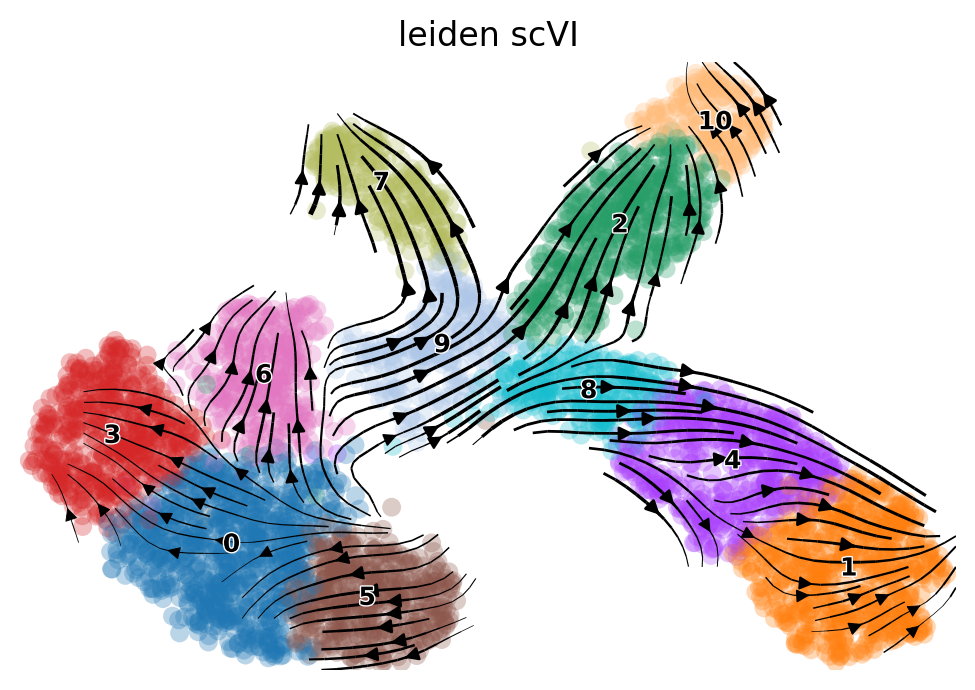

In [72]:
scv.pl.velocity_embedding_stream(adata, 
        basis='X_umap', color='leiden_scVI',
        legend_fontsize=9,
        smooth=0.8, min_mass=4)

Progenitorの部分がごちゃごちゃしてわかりにくいので、取り出して個別に解析してみる。

どうもグルグルとまわってるみたいなので、細胞周期のマーカー遺伝子発現をチェック。

In [73]:
prog = adata[adata.obs['leiden_scVI'].isin(['0', '3', '5'])].copy()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


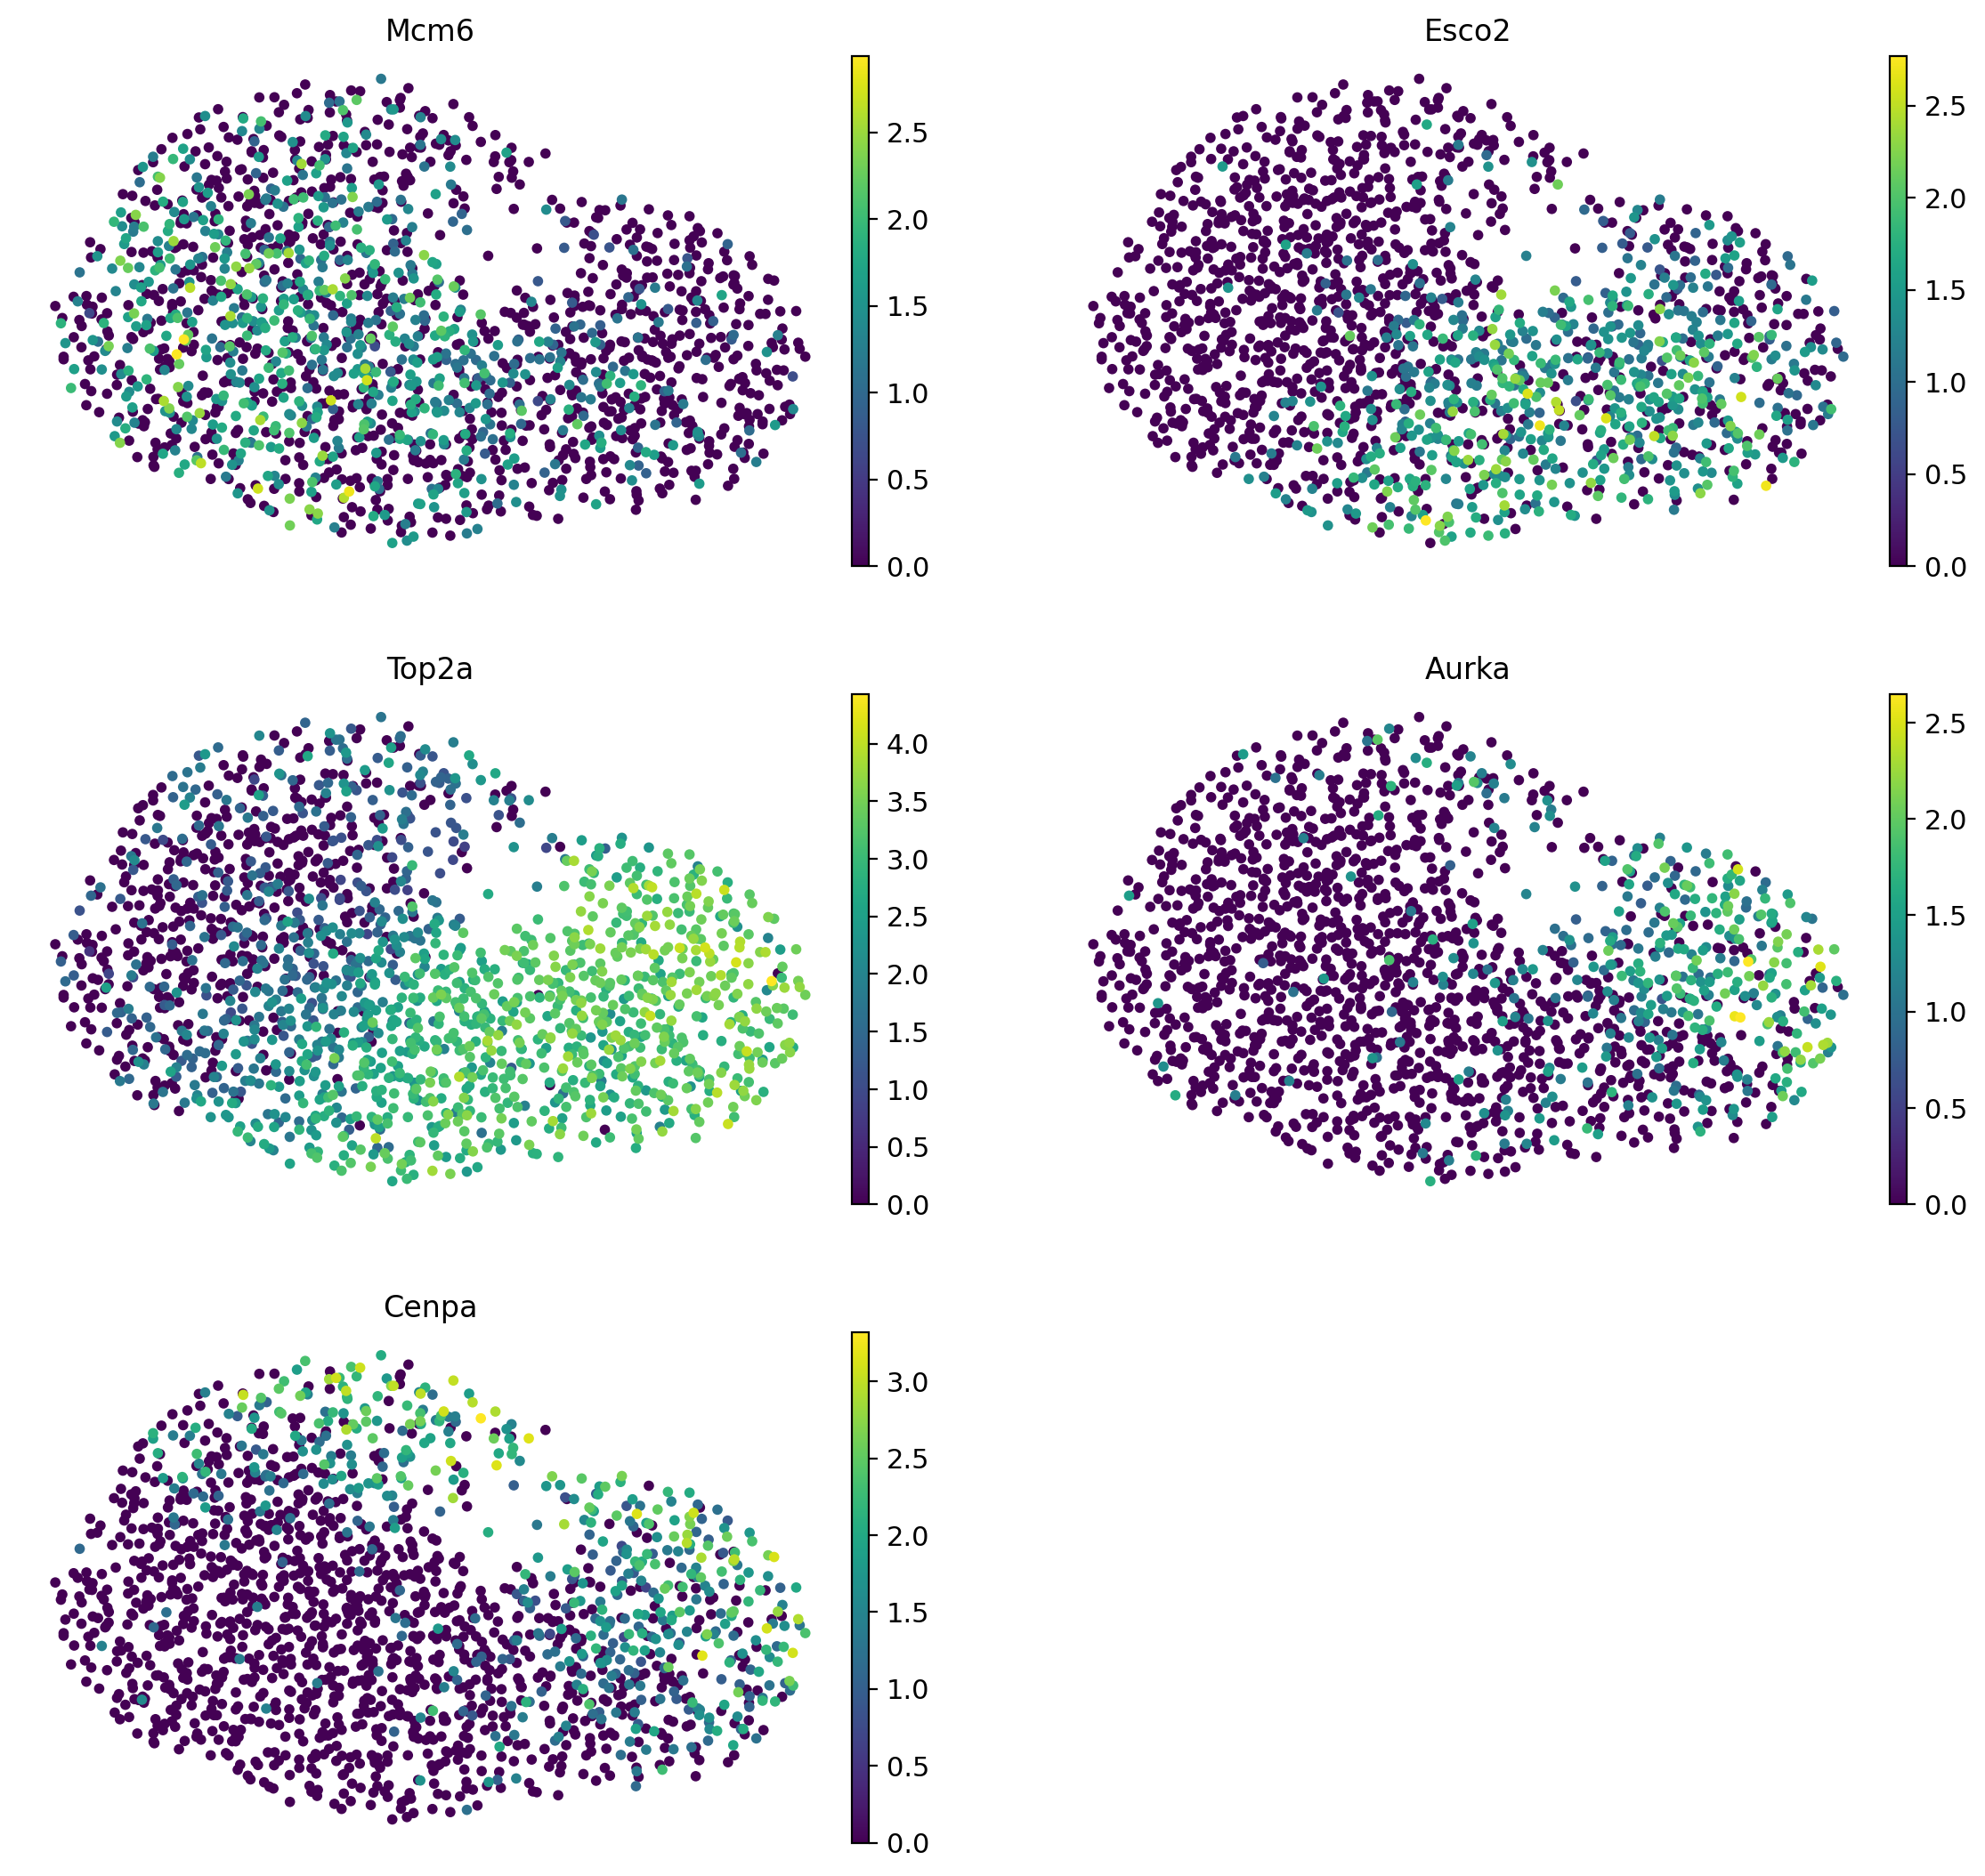

In [74]:
sc.pp.neighbors(prog, use_rep="X_scVI", n_neighbors=50)
sc.tl.umap(prog, min_dist=1.0)
sc.pl.umap(prog, 
           ncols=2,
           color=['Mcm6', 'Esco2', 'Top2a', 'Aurka', 'Cenpa'],
           cmap='viridis',
           frameon=False)

というわけで、このグルグルは細胞周期を反映しているのだった。

この中だけで速度を描くとよりわかりやすい。

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/2 cores)


  0%|          | 0/1704 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


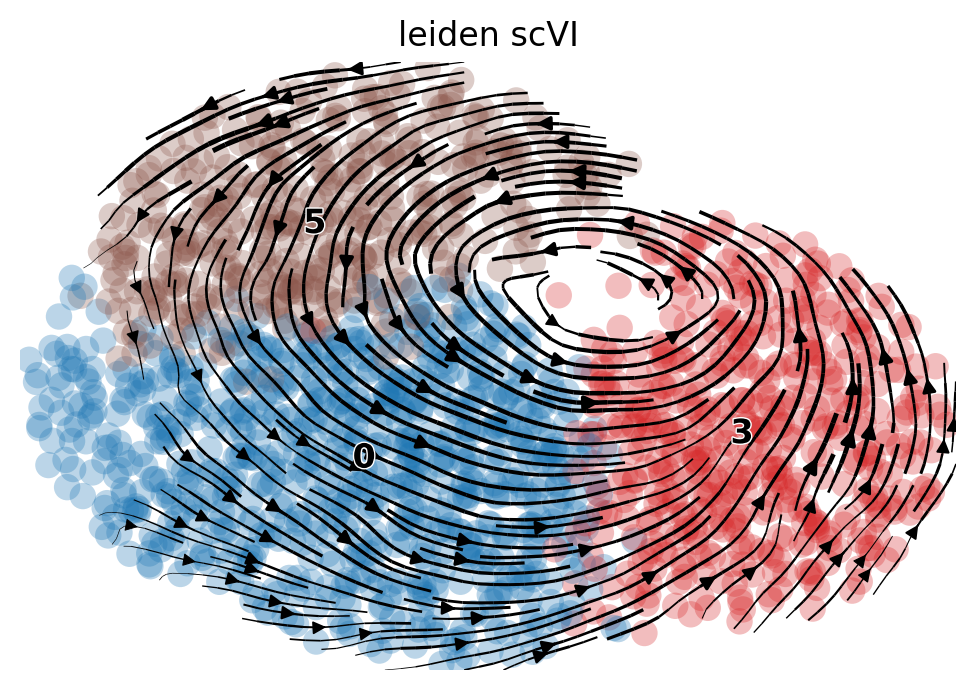

In [75]:
scv.pp.moments(prog, use_rep='X_scVI')
scv.tl.velocity(prog, mode='stochastic')
scv.tl.velocity_graph(prog)
scv.pl.velocity_embedding_stream(prog, 
    basis='X_umap', color='leiden_scVI',
    smooth=0.8, min_mass=4)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
